# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.8 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 64.6 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=2025

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
      dcor_df : The distance correlation matrix as a pandas DataFrame.

    Returns:
      Histogram plot of the distance corelations between features.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates bins with edges at 0, 0.1, ..., 1
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")


**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage.

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
# Model training & Fine-tuning
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
taiwanese_bankruptcy, taiwanese_variables = load_data_from_ucimlrepo(572)

{'uci_id': 572, 'name': 'Taiwanese Bankruptcy Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction', 'data_url': 'https://archive.ics.uci.edu/static/public/572/data.csv', 'abstract': 'The data were collected from the Taiwan Economic Journal  for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6819, 'num_features': 95, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Bankrupt?'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C5004D', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': Non

In [ ]:
taiwanese_bankruptcy.head()

ROA(C) before interest and depreciation before interest  \
0                                           0.370594         
1                                           0.464291         
2                                           0.426071         
3                                           0.399844         
4                                           0.465022         

   ROA(A) before interest and % after tax  \
0                                0.424389   
1                                0.538214   
2                                0.499019   
3                                0.451265   
4                                0.538432   

   ROA(B) before interest and depreciation after tax  Operating Gross Margin  \
0                                           0.405750                0.601457   
1                                           0.516730                0.610235   
2                                           0.472295                0.601450   
3                                           0.457733                0.583541   
4                                           0.522298                0.598783   

   Realized Sales Gross Margin  Operating Profit Rate  \
0                     0.601457               0.998969   
1                     0.610235               0.998946   
2                     0.601364               0.998857   
3                     0.583541               0.998700   
4                     0.598783               0.998973   

   Pre-tax net Interest Rate  After-tax net Interest Rate  \
0                   0.796887                     0.808809   
1                   0.797380                     0.809301   
2                   0.796403                     0.808388   
3                   0.796967                     0.808966   
4                   0.797366                     0.809304   

   Non-industry income and expenditure/revenue  \
0                                     0.302646   
1                                     0.303556   
2                                     0.302035   
3                                     0.303350   
4                                     0.303475   

   Continuous interest rate (after tax)  ...  Total assets to GNP price  \
0                              0.780985  ...                   0.009219   
1                              0.781506  ...                   0.008323   
2                              0.780284  ...                   0.040003   
3                              0.781241  ...                   0.003252   
4                              0.781550  ...                   0.003878   

   No-credit Interval  Gross Profit to Sales  \
0            0.622879               0.601453   
1            0.623652               0.610237   
2            0.623841               0.601449   
3            0.622929               0.583538   
4            0.623521               0.598782   

   Net Income to Stockholder's Equity  Liability to Equity  \
0                            0.827890             0.290202   
1                            0.839969             0.283846   
2                            0.836774             0.290189   
3                            0.834697             0.281721   
4                            0.839973             0.278514   

   Degree of Financial Leverage (DFL)  \
0                            0.026601   
1                            0.264577   
2                            0.026555   
3                            0.026697   
4                            0.024752   

   Interest Coverage Ratio (Interest expense to EBIT)  Net Income Flag  \
0                                           0.564050                 1   
1                                           0.570175                 1   
2                                           0.563706                 1   
3                                           0.564663                 1   
4                                           0.575617                 1   

   Equity to Liability  Target  
0             0.016469       

In [ ]:
taiwanese_variables

name     role        type  \
0                                           Bankrupt?   Target     Integer   
1   ROA(C) before interest and depreciation before...  Feature  Continuous   
2              ROA(A) before interest and % after tax  Feature  Continuous   
3   ROA(B) before interest and depreciation after tax  Feature  Continuous   
4                              Operating Gross Margin  Feature  Continuous   
..                                                ...      ...         ...   
91                                Liability to Equity  Feature  Continuous   
92                 Degree of Financial Leverage (DFL)  Feature  Continuous   
93  Interest Coverage Ratio (Interest expense to E...  Feature  Continuous   
94                                    Net Income Flag  Feature     Integer   
95                                Equity to Liability  Feature  Continuous   

   demographic description units missing_values  
0         None        None  None             no  
1         None        None  None             no  
2         None        None  None             no  
3         None        None  None             no  
4         None        None  None             no  
..         ...         ...   ...            ...  
91        None        None  None             no  
92        None        None  None             no  
93        None        None  None             no  
94        None        None  None             no  
95        None        None  None             no  

[96 rows x 7 columns]

# **Data summary and quality**

In [ ]:
describe_data(taiwanese_bankruptcy)


Data dimension :
Number of Records :  6819 
Number of Features :  96

Datatype of Features :
float64    93
int64       3
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Duplicated records not identified

Data summary :
       ROA(C) before interest and depreciation before interest  \
count                                        6819.000000         
mean                                            0.505180         
std                                             0.060686         
min                                             0.000000         
25%                                             0.476527         
50%                                             0.502706         
75%                                             0.535563         
max                                             1.000000         

       ROA(A) before interest and % after tax  \
count                             6819.000000   
mean                                 0.

# **Split data in train and test set**

In [ ]:
taiwanese_bankruptcy_train, taiwanese_bankruptcy_test = train_test_split(
    taiwanese_bankruptcy, test_size=0.20, random_state=RANDOM_STATE,
    stratify=taiwanese_bankruptcy["Target"]
)
taiwanese_bankruptcy_train['Target'].value_counts()

Target
0    5279
1     176
Name: count, dtype: int64

In [ ]:
taiwanese_bankruptcy_test['Target'].value_counts()

Target
0    1320
1      44
Name: count, dtype: int64

# **Correlation**

In [ ]:
taiwanese_bankruptcy_train.dtypes

ROA(C) before interest and depreciation before interest    float64
ROA(A) before interest and % after tax                     float64
ROA(B) before interest and depreciation after tax          float64
Operating Gross Margin                                     float64
Realized Sales Gross Margin                                float64
                                                            ...   
Degree of Financial Leverage (DFL)                         float64
Interest Coverage Ratio (Interest expense to EBIT)         float64
Net Income Flag                                              int64
Equity to Liability                                        float64
Target                                                       int64
Length: 96, dtype: object

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

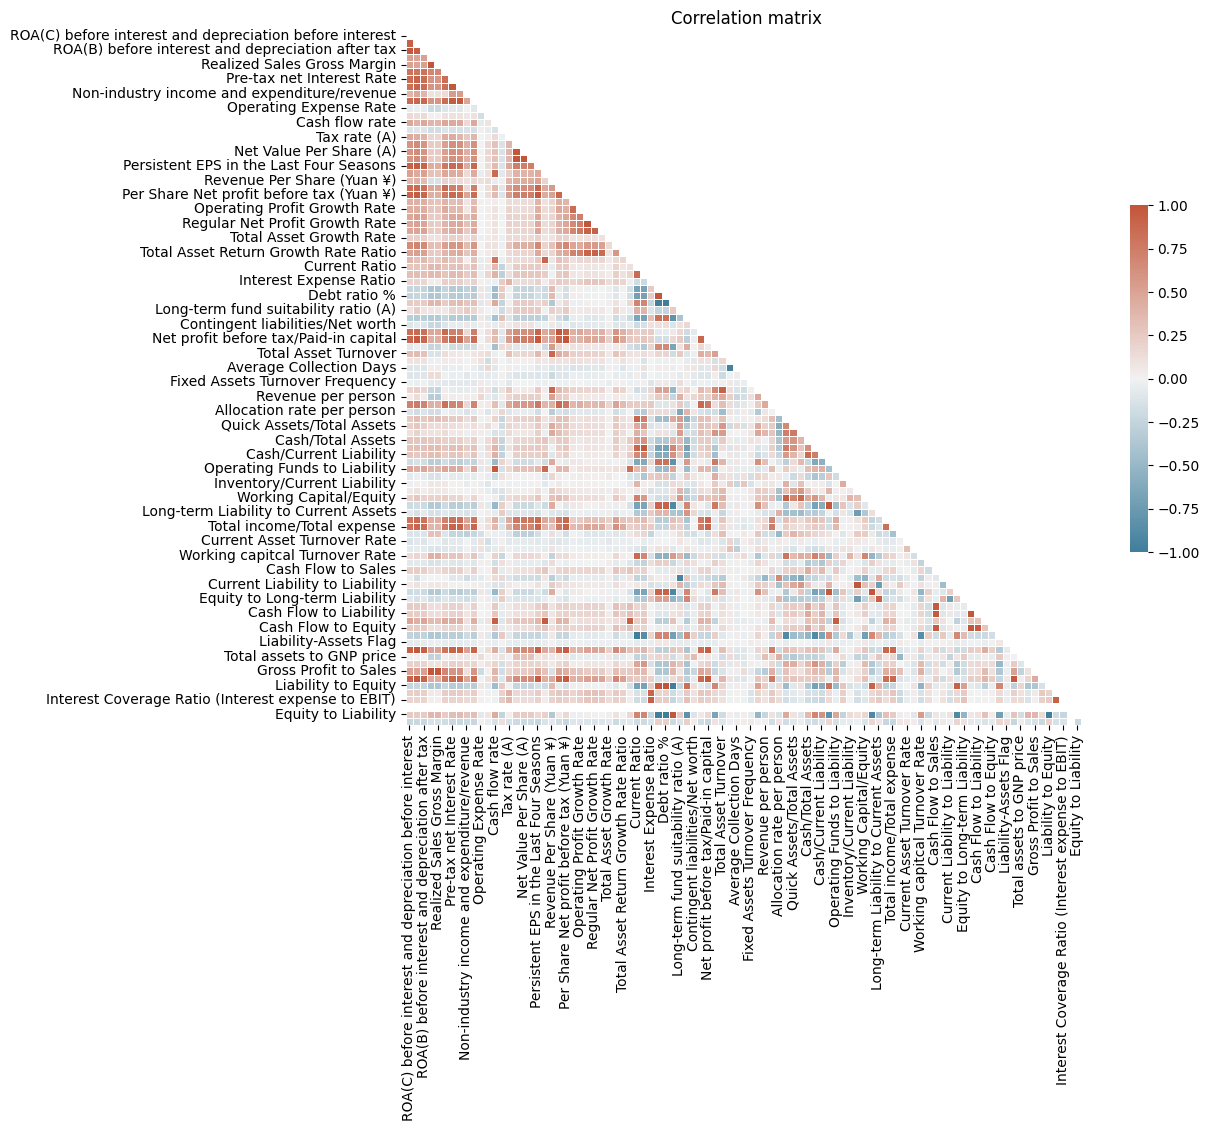

In [ ]:
taiwan_corr = calculate_correlation(taiwanese_bankruptcy_train, 'spearman')

In [ ]:
abs(taiwan_corr['Target']).sort_values(ascending=False)

Target                                      1.000000
Persistent EPS in the Last Four Seasons     0.237251
Net Income to Total Assets                  0.234639
Net profit before tax/Paid-in capital       0.232964
Per Share Net profit before tax (Yuan ¥)    0.232289
                                              ...   
Cash Turnover Rate                          0.016342
Operating Expense Rate                      0.015004
Revenue per person                          0.014447
Net Worth Turnover Rate (times)             0.004070
Net Income Flag                                  NaN
Name: Target, Length: 96, dtype: float64

df columns:  Index(['ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate', 'Cash flow rate',
       'Interest-bearing debt interest rate', 'Tax rate (A)',
       'Net Value Per Share (B)', 'Net Value Per Share (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating Profit Growth Rate', 'After-tax

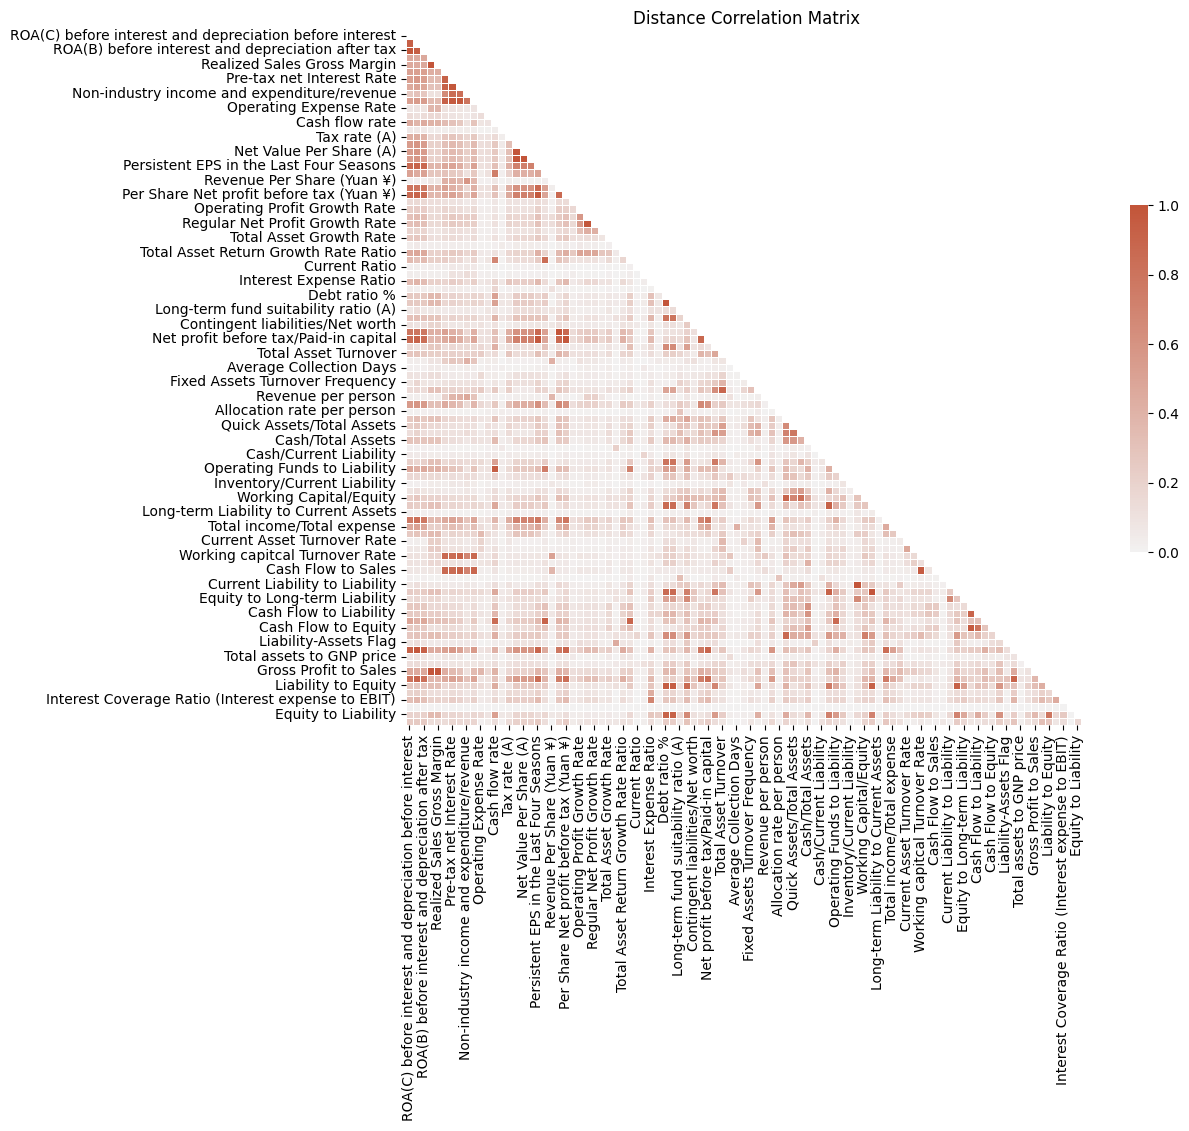

In [ ]:
taiwan_dist_corr = calculate_distance_correlation_matrix(taiwanese_bankruptcy_train)

In [ ]:
taiwan_dist_corr['Target'].sort_values(ascending=False)

Target                                1.000000
Net Income to Stockholder's Equity    0.326439
Borrowing dependency                  0.293049
Net Income to Total Assets            0.284681
Retained Earnings to Total Assets     0.272502
                                        ...   
Inventory/Current Liability           0.005592
Revenue Per Share (Yuan ¥)            0.004946
Quick Assets/Current Liability        0.004280
Current Ratio                         0.002472
Net Income Flag                       0.000000
Name: Target, Length: 96, dtype: float64

# **Pre-feature selection**
Features with zero-variance will be dropped. The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
filtered_features = filter_out_intercorrelated_features(taiwan_dist_corr, 'Target', 0.8)

appended feature:  Net Income to Stockholder's Equity
eliminated feature:  Net Income to Total Assets 0.8936021693923298
eliminated feature:  ROA(A) before interest and % after tax 0.8846014762494652
eliminated feature:  ROA(B) before interest and depreciation after tax 0.8212433093824045
eliminated feature:  Persistent EPS in the Last Four Seasons 0.8372269110916617
eliminated feature:  ROA(C) before interest and depreciation before interest 0.8080800916836077
eliminated feature:  Net profit before tax/Paid-in capital 0.838590891159282
eliminated feature:  Per Share Net profit before tax (Yuan ¥) 0.835522613001148
appended feature:  Borrowing dependency
eliminated feature:  Liability to Equity 0.8585354792380225
appended feature:  Retained Earnings to Total Assets
appended feature:  Current Liabilities/Equity
eliminated feature:  Current Liability to Equity 0.999999999929129
eliminated feature:  Debt ratio % 0.8520719525785985
eliminated feature:  Net worth/Assets 0.8520719525580661
e

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.01

taiwan_zero_variance_columns = identify_zero_variance_columns(taiwanese_bankruptcy_train[filtered_features])

if DROP_WEAK_FEATURES:
  taiwan_weak_features = identify_weak_associated_features(taiwan_dist_corr, "Target", WEAK_THRESHOLD)
else:
  taiwan_weak_features = []

remove_columns = set(taiwan_zero_variance_columns + taiwan_weak_features)
remove_columns = [col for col in remove_columns if col in filtered_features]
print(remove_columns)

taiwanese_bankruptcy_train = taiwanese_bankruptcy_train[filtered_features + ['Target']].drop(columns=remove_columns)
taiwanese_bankruptcy_test = taiwanese_bankruptcy_test[filtered_features + ['Target']].drop(columns=remove_columns)

Variance of each column:
Net Income to Stockholder's Equity     2.585918e-04
Borrowing dependency                   3.184116e-04
Retained Earnings to Total Assets      6.875513e-04
Current Liabilities/Equity             2.179479e-04
Current Liability to Current Assets    1.066577e-03
                                           ...     
Inventory/Current Liability            3.764583e+17
Revenue Per Share (Yuan ¥)             1.671014e+15
Quick Assets/Current Liability         3.681583e+16
Current Ratio                          1.386343e+15
Net Income Flag                        0.000000e+00
Length: 62, dtype: float64
Columns with zero variance to be dropped:
['Net Income Flag']
['Net Income Flag']


In [ ]:
print('Original number of features: ', len(taiwanese_bankruptcy.columns))
print('Number of features after pre-feature selection: ', len(taiwanese_bankruptcy_train.columns))

Original number of features:  96
Number of features after pre-feature selection:  62


# **Imbalanced dataset**

In [ ]:
X_train = taiwanese_bankruptcy_train.drop('Target', axis=1)
y_train = taiwanese_bankruptcy_train['Target']

X_test = taiwanese_bankruptcy_test.drop('Target', axis=1)
y_test = taiwanese_bankruptcy_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0      5279    0.967736
1.0       176    0.032264

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
taiwan_imputation_values_dict = calculate_imputation_values_for_missing(taiwanese_bankruptcy_train)
taiwan_imputation_values_dict

{"Net Income to Stockholder's Equity": 0.841175087102042,
 'Borrowing dependency': 0.372660110091415,
 'Retained Earnings to Total Assets': 0.937648424758875,
 'Current Liabilities/Equity': 0.329678742849431,
 'Current Liability to Current Assets': 0.0277473716469437,
 'Net Value Per Share (A)': 0.184273734777296,
 'Continuous interest rate (after tax)': 0.781634255356715,
 'Working Capital/Equity': 0.735974926993371,
 'Operating Profit Per Share (Yuan ¥)': 0.104144613630812,
 'Operating profit per person': 0.39587526288415,
 'Equity to Long-term Liability': 0.112363191254745,
 'Equity to Liability': 0.0336884041237536,
 'Tax rate (A)': 0.0740965684785909,
 'Total income/Total expense': 0.0023353042703219,
 'Liability-Assets Flag': 0.0,
 'Operating Gross Margin': 0.605997492036495,
 'Interest Expense Ratio': 0.630699921918878,
 'CFO to Assets': 0.59343594595975,
 'Interest Coverage Ratio (Interest expense to EBIT)': 0.565254146067448,
 'Inventory and accounts receivable/Net value': 0.4

In [ ]:
taiwan_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
taiwan_cat_vars

['Liability-Assets Flag']

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
    'max_depth': [None],
    'min_samples_split': [0.005],
    'min_samples_leaf': [0.001]
}

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 15:51:34.947069

Nested Cross-validation Results:
Individual scores: [0.3655914  0.27586207 0.25906736]
Average nested CV score: 0.300 (+/- 0.094)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005}

Best Model Performance:
Best CV score: 0.300
2025-01-16 15:51:38.730487

Execution time: 0.06 minutes




```
Starting hyperparameter tuning at: 2025-01-15 18:42:53.581578

Nested Cross-validation Results:
Individual scores: [0.32713755 0.30952381 0.25906736]
Average nested CV score: 0.299 (+/- 0.058)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005}

Best Model Performance:
Best CV score: 0.300
2025-01-15 18:43:25.716421

Execution time: 0.54 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
46                         Total debt/Total net worth    0.204709  0.016790
36                              Net Value Growth Rate    0.204181  0.008099
2                   Retained Earnings to Total Assets    0.175795  0.007915
6                Continuous interest rate (after tax)    0.149055  0.011626
44                                        Quick Ratio    0.118710  0.007374
16                             Interest Expense Ratio    0.058252  0.006094
11                                Equity to Liability    0.049409  0.004349
34                            Total Asset Growth Rate    0.038921  0.014730
9                         Operating profit per person    0.035922  0.005214
37                       Operating Profit Growth Rate    0.034911  0.004680
53                        Current Asset Turnover Rate    0.025781  0.001308
43                                 Cash Turnover Rate    0.025483  0.006260
49                    Inventory Turnover Rate (times)    0.024064  0.002915
32                             Cash Flow to Liability    0.023525  0.003961
25                          Inventory/Working Capital    0.018537  0.003699
51                         Allocation rate per person    0.018458  0.002384
10                      Equity to Long-term Liability    0.017310  0.002727
0                  Net Income to Stockholder's Equity    0.017193  0.002333
17                                      CFO to Assets    0.015548  0.004044
40                                 Revenue per person    0.014214  0.003144
58                         Revenue Per Share (Yuan ¥)    0.013990  0.003897
45                          Quick Asset Turnover Rate    0.012972  0.005526
48                Interest-bearing debt interest rate    0.011578  0.003978
47                          Total assets to GNP price    0.010608  0.001526
31                    Fixed Assets Turnover Frequency    0.010228  0.003220
56                            Average Collection Days    0.009691  0.001675
50                      Current Liabilities/Liability    0.009370  0.002870
19        Inventory and accounts receivable/Net value    0.009037  0.002463
57                        Inventory/Current Liability    0.008237  0.003365
21                             Cash/Current Liability    0.008231  0.002635
18  Interest Coverage Ratio (Interest expense to E...    0.007353  0.001982
52                             Operating Expense Rate    0.007293  0.002547
1                                Borrowing dependency    0.006169  0.002787
20                               Total expense/Assets   -0.001820  0.000719

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

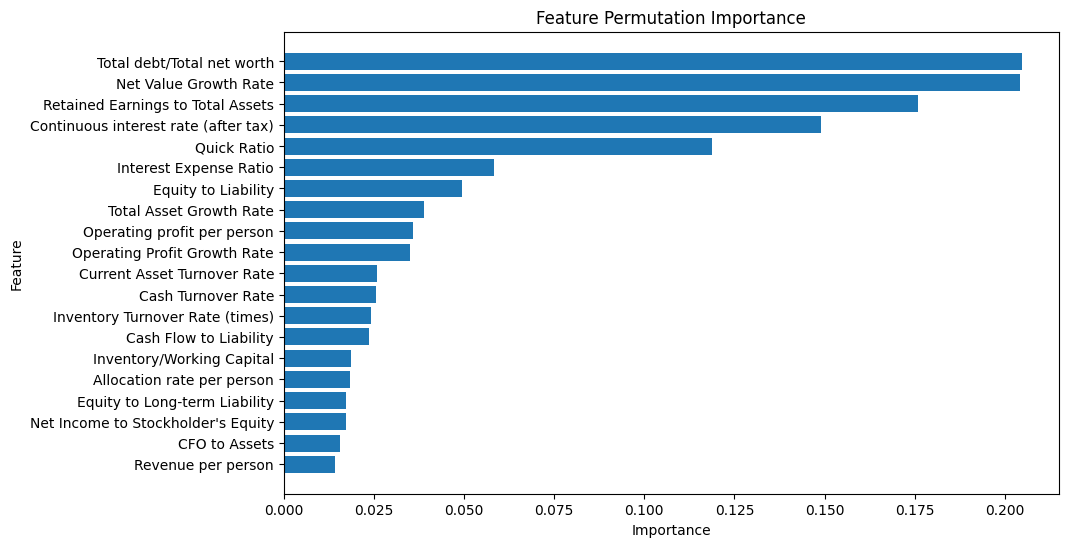

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    taiwan_imputation_values_dict, 20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Net Value Growth Rate
Original feat removed so far:  ['Total debt/Total net worth', 'Net Value Growth Rate']

--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Original feat removed so far:  ['Total debt/Total net worth', 'Net Value Growth Rate', 'Retained Earnings to Total Assets']

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Original feat removed so far:  ['Total debt/Total net worth', 'Net Value Growth Rate', 'Retained Earnings to Total Assets', 'Continuous interest rate (after tax)']

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Total debt/Total net worth', 'Net Value Growth Rate', 'Retained Earnings to Total Assets', 'Continuous interest rate (after tax)', 'Quick Ratio']

--- NEW ITERATION ---
Removing feature:  

In [ ]:
dt_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   19  1229  91  25      17.27   43.18        93.11     91.50     24.68   
1    9  1268  52  35      14.75   20.45        96.06     93.62     17.14   
2    9  1273  47  35      16.07   20.45        96.44     93.99     18.00   
3    9  1273  47  35      16.07   20.45        96.44     93.99     18.00   
4    2  1284  36  42       5.26    4.55        97.27     94.28      4.88   
5    2  1284  36  42       5.26    4.55        97.27     94.28      4.88   
6    2  1301  19  42       9.52    4.55        98.56     95.53      6.15   
7    2  1301  19  42       9.52    4.55        98.56     95.53      6.15   
8    2  1301  19  42       9.52    4.55        98.56     95.53      6.15   
9    2  1301  19  42       9.52    4.55        98.56     95.53      6.15   
10   2  1301  19  42       9.52    4.55        98.56     95.53      6.15   
11   2  1301  19  42       9.52    4.55        98.56     95.53      6.15   
12   2  1302  18  42      10.00    4.55        98.64     95.60      6.25   
13   2  1302  18  42      10.00    4.55        98.64     95.60      6.25   
14   2  1302  18  42      10.00    4.55        98.64     95.60      6.25   
15   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               68.14                 0   
1               58.26                 1   
2               58.45                 2   
3               58.45                 3   
4               50.91                 4   
5               50.91                 5   
6               51.55                 6   
7               51.55                 7   
8               51.55                 8   
9               51.55                 9   
10              51.55                10   
11              51.55                11   
12              51.59                12   
13              51.59                13   
14              51.59                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1              ['Total debt/Total net worth'] imputed  
2   ['Total debt/Total net worth', 'Net Value Grow...  
3   ['Total debt/Total net worth', 'Net Value Grow...  
4   ['Total debt/Total net worth', 'Net Value Grow...  
5   ['Total debt/Total net worth', 'Net Value Grow...  
6   ['Total debt/Total net worth', 'Net Value Grow...  
7   ['Total debt/Total net worth', 'Net Value Grow...  
8   ['Total debt/Total net worth', 'Net Value Grow...  
9   ['Total debt/Total net worth', 'Net Value Grow...  
10  ['Total debt/Total net worth', 'Net Value Grow...  
11  ['Total debt/Total net worth', 'Net Value Grow...  
12  ['Total debt/Total net worth', 'Net Value Grow...  
13  ['Total debt/Total net worth', 'Net Value Grow...  
14  ['Total debt/Total net worth', 'Net Value Grow...  
15  ['Total debt/Total net worth', 'Net Value Grow...  
16  ['Total debt/Total net worth', 'Net Value Grow...  
17  ['Total debt/Total net worth', 'Net Value Grow...  
18  ['Total debt/Total net worth', 'Net Value Grow...  
19  ['Total debt/Total net worth', 'Net Value Grow...  
20  ['Total debt/Total net worth', 'Net Value Grow...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 15:51:41.097943

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Assets', 'Tota

In [ ]:
dt_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   19  1229   91  25      17.27   43.18        93.11     91.50     24.68   
1   19  1223   97  25      16.38   43.18        92.65     91.06     23.75   
2   14  1250   70  30      16.67   31.82        94.70     92.67     21.88   
3   14  1245   75  30      15.73   31.82        94.32     92.30     21.05   
4   15  1248   72  29      17.24   34.09        94.55     92.60     22.90   
5   13  1238   82  31      13.68   29.55        93.79     91.72     18.71   
6   14  1248   72  30      16.28   31.82        94.55     92.52     21.54   
7   15  1226   94  29      13.76   34.09        92.88     90.98     19.61   
8   14  1235   85  30      14.14   31.82        93.56     91.57     19.58   
9   13  1235   85  31      13.27   29.55        93.56     91.50     18.31   
10  14  1238   82  30      14.58   31.82        93.79     91.79     20.00   
11  14  1236   84  30      14.29   31.82        93.64     91.64     19.72   
12  15  1232   88  29      14.56   34.09        93.33     91.42     20.41   
13  15  1234   86  29      14.85   34.09        93.48     91.57     20.69   
14  16  1237   83  28      16.16   36.36        93.71     91.86     22.38   
15  14  1238   82  30      14.58   31.82        93.79     91.79     20.00   
16  21  1222   98  23      17.65   47.73        92.58     91.13     25.77   
17  20  1219  101  24      16.53   45.45        92.35     90.84     24.24   
18  19  1233   87  25      17.92   43.18        93.41     91.79     25.33   
19  21  1230   90  23      18.92   47.73        93.18     91.72     27.10   
20  19  1240   80  25      19.19   43.18        93.94     92.30     26.57   

    balanced_accuracy  num_feat_missing  \
0               68.14                 0   
1               67.92                 1   
2               63.26                 2   
3               63.07                 3   
4               64.32                 4   
5               61.67                 5   
6               63.18                 6   
7               63.48                 7   
8               62.69                 8   
9               61.55                 9   
10              62.80                10   
11              62.73                11   
12              63.71                12   
13              63.79                13   
14              65.04                14   
15              62.80                15   
16              70.15                16   
17              68.90                17   
18              68.30                18   
19              70.45                19   
20              68.56                20   

                                              imputed  
0                                                      
1              ['Total debt/Total net worth'] imputed  
2   ['Total debt/Total net worth', 'Net Value Grow...  
3   ['Total debt/Total net worth', 'Net Value Grow...  
4   ['Total debt/Total net worth', 'Net Value Grow...  
5   ['Total debt/Total net worth', 'Net Value Grow...  
6   ['Total debt/Total net worth', 'Net Value Grow...  
7   ['Total debt/Total net worth', 'Net Value Grow...  
8   ['Total debt/Total net worth', 'Net Value Grow...  
9   ['Total debt/Total net worth', 'Net Value Grow...  
10  ['Total debt/Total net worth', 'Net Value Grow...  
11  ['Total debt/Total net worth', 'Net Value Grow...  
12  ['Total debt/Total net worth', 'Net Value Grow...  
13  ['Total debt/Total net worth', 'Net Value Grow...  
14  ['Total debt/Total net worth', 'Net Value Grow...  
15  ['Total debt/Total net worth', 'Net Value Grow...  
16  ['Total debt/Total net worth', 'Net Value Grow...  
17  ['Total debt/Total net worth', 'Net Value Grow...  
18  ['Total debt/Total net worth', 'Net Value Grow...  
19  ['Total debt/Total net worth', 'Net Value Grow...  
20  ['Total debt/Total net worth', 'Net Value Grow...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  #best model
  rf_param_grid = {
      'n_estimators': [200],
      'max_features': [0.5],
      'min_samples_split': [0.01],
      'min_samples_leaf': [0.005],
      'max_depth': [None]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(
    rf_classifier, rf_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 15:59:40.164011

Nested Cross-validation Results:
Individual scores: [0.45977011 0.44444444 0.46857143]
Average nested CV score: 0.458 (+/- 0.020)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.005, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.458
2025-01-16 16:00:24.308941

Execution time: 0.74 minutes




```
Starting hyperparameter tuning at: 2025-01-16 04:42:30.609383

Nested Cross-validation Results:
Individual scores: [0.45454545 0.43979058 0.38095238]
Average nested CV score: 0.425 (+/- 0.064)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.005, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.458
2025-01-16 05:49:32.715934

Execution time: 67.04 minutes
```



In [ ]:
# rf_grid_search.cv_results_

In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
16                             Interest Expense Ratio    0.015358  0.002945
48                Interest-bearing debt interest rate    0.009366  0.004787
43                                 Cash Turnover Rate    0.009181  0.002676
37                       Operating Profit Growth Rate    0.008551  0.002733
56                            Average Collection Days    0.007656  0.001127
51                         Allocation rate per person    0.007344  0.003245
55                       Accounts Receivable Turnover    0.007049  0.002351
35                             Fixed Assets to Assets    0.004654  0.000875
52                             Operating Expense Rate    0.004223  0.001777
24                   After-tax Net Profit Growth Rate    0.004059  0.001248
45                          Quick Asset Turnover Rate    0.003958  0.000736
9                         Operating profit per person    0.003893  0.001671
33                 Degree of Financial Leverage (DFL)    0.003566  0.001663
21                             Cash/Current Liability    0.003532  0.003050
28                          Quick Assets/Total Assets    0.003068  0.001764
25                          Inventory/Working Capital    0.002970  0.001670
39               Long-term fund suitability ratio (A)    0.002804  0.000405
40                                 Revenue per person    0.002445  0.000991
15                             Operating Gross Margin    0.002438  0.001372
53                        Current Asset Turnover Rate    0.002277  0.001329
49                    Inventory Turnover Rate (times)    0.002245  0.001831
8                 Operating Profit Per Share (Yuan ¥)    0.002003  0.001157
31                    Fixed Assets Turnover Frequency    0.001976  0.000406
12                                       Tax rate (A)    0.001740  0.001464
20                               Total expense/Assets    0.001611  0.001865
58                         Revenue Per Share (Yuan ¥)    0.001511  0.002710
4                 Current Liability to Current Assets    0.001488  0.001095
22               Total Asset Return Growth Rate Ratio    0.001278  0.001217
38                  Continuous Net Profit Growth Rate    0.001146  0.001830
41            Realized Sales Gross Profit Growth Rate    0.001015  0.001297
42              Research and development expense rate    0.000663  0.000620
27                                Cash Flow to Equity    0.000420  0.002316
30                   Contingent liabilities/Net worth    0.000332  0.000406
7                              Working Capital/Equity    0.000259  0.001041
54              Long-term Liability to Current Assets    0.000258  0.001071
47                          Total assets to GNP price   -0.000002  0.001052
57                        Inventory/Current Liability   -0.000004  0.001392
50                      Current Liabilities/Liability   -0.000037  0.000995
29                               Total Asset Turnover   -0.000076  0.000751
60                                      Current Ratio   -0.000280  0.002709
10                      Equity to Long-term Liability   -0.000302  0.002352
19        Inventory and accounts receivable/Net value   -0.000407  0.000913
26                                 No-credit Interval   -0.000667  0.001105
18  Interest Coverage Ratio (Interest expense to E...   -0.001731  0.002381
34                            Total Asset Growth Rate   -0.002588  0.001827
17                                      CFO to Assets   -0.002744  0.001611
23                                  Cash/Total Assets   -0.003511  0.001338
32                             Cash Flow to Liability   -0.004823  0.001190
3                          Current Liabilities/Equity   -0.006031  0.002979
59                     Quick Assets/Current Liability   -0.006702  0.002616
1                                Borrowing dependency   -0.010866  0.006828
5                             Net Value Per Share (A)   -0.017167  0.003564
0                 

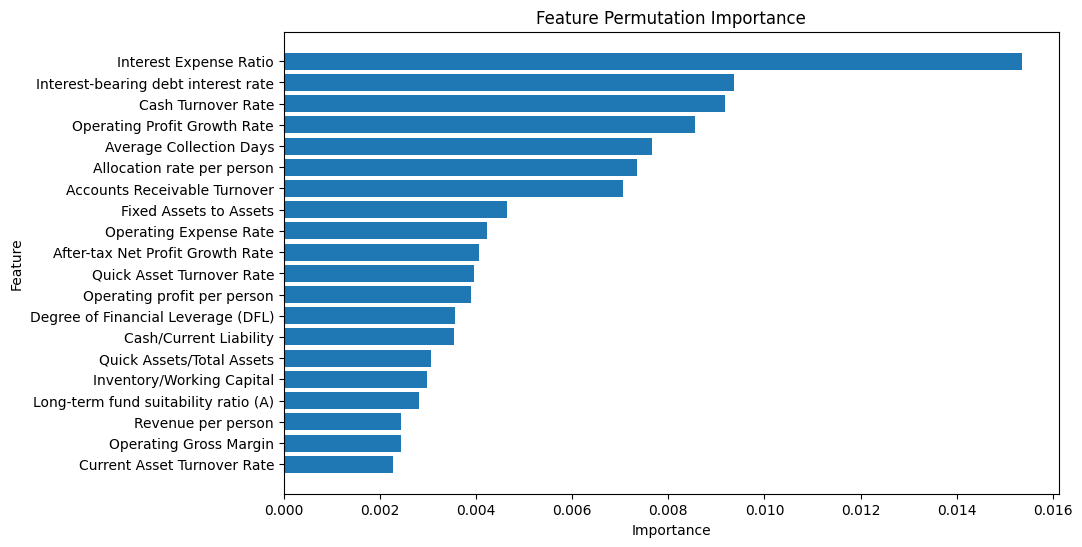

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Interest Expense Ratio']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Interest Expense Ratio', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Interest Expense Ratio', 'Interest-bearing debt interest rate', 'Cash Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Operating Profit Growth Rate
Original feat removed so far:  ['Interest Expense Ratio', 'Interest-bearing debt interest rate', 'Cash Turnover Rate', 'Operating Profit Growth Rate']

--- NEW ITERATION ---
Removing feature:  Average Collection Days
Original feat removed so far:  ['Interest Expense Ratio', 'Interest-bearing debt interest rate', 'Cash Turnover Rate', 'Operating Profit Growth Rate', 'Average Collection Days']

--- NEW ITERATION ---
Removing feature:  Allocation rat

In [ ]:
rf_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   33  1242  78  11      29.73   75.00        94.09     93.48     42.58   
1   33  1244  76  11      30.28   75.00        94.24     93.62     43.14   
2   30  1247  73  14      29.13   68.18        94.47     93.62     40.82   
3   30  1247  73  14      29.13   68.18        94.47     93.62     40.82   
4   30  1246  74  14      28.85   68.18        94.39     93.55     40.54   
5   30  1246  74  14      28.85   68.18        94.39     93.55     40.54   
6   30  1247  73  14      29.13   68.18        94.47     93.62     40.82   
7   30  1247  73  14      29.13   68.18        94.47     93.62     40.82   
8   30  1248  72  14      29.41   68.18        94.55     93.70     41.10   
9   30  1248  72  14      29.41   68.18        94.55     93.70     41.10   
10  30  1247  73  14      29.13   68.18        94.47     93.62     40.82   
11  30  1248  72  14      29.41   68.18        94.55     93.70     41.10   
12  30  1249  71  14      29.70   68.18        94.62     93.77     41.38   
13  30  1250  70  14      30.00   68.18        94.70     93.84     41.67   
14  30  1250  70  14      30.00   68.18        94.70     93.84     41.67   
15  30  1249  71  14      29.70   68.18        94.62     93.77     41.38   
16  30  1248  72  14      29.41   68.18        94.55     93.70     41.10   
17  30  1248  72  14      29.41   68.18        94.55     93.70     41.10   
18  30  1248  72  14      29.41   68.18        94.55     93.70     41.10   
19  30  1248  72  14      29.41   68.18        94.55     93.70     41.10   
20  29  1248  72  15      28.71   65.91        94.55     93.62     40.00   

    balanced_accuracy  num_feat_missing  \
0               84.55                 0   
1               84.62                 1   
2               81.33                 2   
3               81.33                 3   
4               81.29                 4   
5               81.29                 5   
6               81.33                 6   
7               81.33                 7   
8               81.36                 8   
9               81.36                 9   
10              81.33                10   
11              81.36                11   
12              81.40                12   
13              81.44                13   
14              81.44                14   
15              81.40                15   
16              81.36                16   
17              81.36                17   
18              81.36                18   
19              81.36                19   
20              80.23                20   

                                              imputed  
0                                                      
1                  ['Interest Expense Ratio'] imputed  
2   ['Interest Expense Ratio', 'Interest-bearing d...  
3   ['Interest Expense Ratio', 'Interest-bearing d...  
4   ['Interest Expense Ratio', 'Interest-bearing d...  
5   ['Interest Expense Ratio', 'Interest-bearing d...  
6   ['Interest Expense Ratio', 'Interest-bearing d...  
7   ['Interest Expense Ratio', 'Interest-bearing d...  
8   ['Interest Expense Ratio', 'Interest-bearing d...  
9   ['Interest Expense Ratio', 'Interest-bearing d...  
10  ['Interest Expense Ratio', 'Interest-bearing d...  
11  ['Interest Expense Ratio', 'Interest-bearing d...  
12  ['Interest Expense Ratio', 'Interest-bearing d...  
13  ['Interest Expense Ratio', 'Interest-bearing d...  
14  ['Interest Expense Ratio', 'Interest-bearing d...  
15  ['Interest Expense Ratio', 'Interest-bearing d...  
16  ['Interest Expense Ratio', 'Interest-bearing d...  
17  ['Interest Expense Ratio', 'Interest-bearing d...  
18  ['Interest Expense Ratio', 'Interest-bearing d...  
19  ['Interest Expense Ratio', 'Interest-bearing d...  
20  ['Interest Expense Ratio', 'Interest-bearing d...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 16:00:44.542077

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Assets', 'Total As

In [ ]:
rf_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   33  1242  78  11      29.73   75.00        94.09     93.48     42.58   
1   33  1242  78  11      29.73   75.00        94.09     93.48     42.58   
2   33  1240  80  11      29.20   75.00        93.94     93.33     42.04   
3   34  1242  78  10      30.36   77.27        94.09     93.55     43.59   
4   34  1244  76  10      30.91   77.27        94.24     93.70     44.16   
5   34  1243  77  10      30.63   77.27        94.17     93.62     43.87   
6   34  1242  78  10      30.36   77.27        94.09     93.55     43.59   
7   33  1243  77  11      30.00   75.00        94.17     93.55     42.86   
8   33  1242  78  11      29.73   75.00        94.09     93.48     42.58   
9   33  1242  78  11      29.73   75.00        94.09     93.48     42.58   
10  32  1242  78  12      29.09   72.73        94.09     93.40     41.56   
11  33  1242  78  11      29.73   75.00        94.09     93.48     42.58   
12  33  1241  79  11      29.46   75.00        94.02     93.40     42.31   
13  33  1241  79  11      29.46   75.00        94.02     93.40     42.31   
14  33  1241  79  11      29.46   75.00        94.02     93.40     42.31   
15  33  1240  80  11      29.20   75.00        93.94     93.33     42.04   
16  33  1242  78  11      29.73   75.00        94.09     93.48     42.58   
17  33  1242  78  11      29.73   75.00        94.09     93.48     42.58   
18  33  1241  79  11      29.46   75.00        94.02     93.40     42.31   
19  33  1242  78  11      29.73   75.00        94.09     93.48     42.58   
20  33  1242  78  11      29.73   75.00        94.09     93.48     42.58   

    balanced_accuracy  num_feat_missing  \
0               84.55                 0   
1               84.55                 1   
2               84.47                 2   
3               85.68                 3   
4               85.76                 4   
5               85.72                 5   
6               85.68                 6   
7               84.58                 7   
8               84.55                 8   
9               84.55                 9   
10              83.41                10   
11              84.55                11   
12              84.51                12   
13              84.51                13   
14              84.51                14   
15              84.47                15   
16              84.55                16   
17              84.55                17   
18              84.51                18   
19              84.55                19   
20              84.55                20   

                                              imputed  
0                                                      
1                  ['Interest Expense Ratio'] imputed  
2   ['Interest Expense Ratio', 'Interest-bearing d...  
3   ['Interest Expense Ratio', 'Interest-bearing d...  
4   ['Interest Expense Ratio', 'Interest-bearing d...  
5   ['Interest Expense Ratio', 'Interest-bearing d...  
6   ['Interest Expense Ratio', 'Interest-bearing d...  
7   ['Interest Expense Ratio', 'Interest-bearing d...  
8   ['Interest Expense Ratio', 'Interest-bearing d...  
9   ['Interest Expense Ratio', 'Interest-bearing d...  
10  ['Interest Expense Ratio', 'Interest-bearing d...  
11  ['Interest Expense Ratio', 'Interest-bearing d...  
12  ['Interest Expense Ratio', 'Interest-bearing d...  
13  ['Interest Expense Ratio', 'Interest-bearing d...  
14  ['Interest Expense Ratio', 'Interest-bearing d...  
15  ['Interest Expense Ratio', 'Interest-bearing d...  
16  ['Interest Expense Ratio', 'Interest-bearing d...  
17  ['Interest Expense Ratio', 'Interest-bearing d...  
18  ['Interest Expense Ratio', 'Interest-bearing d...  
19  ['Interest Expense Ratio', 'Interest-bearing d...  
20  ['Interest Expense Ratio', 'Interest-bearing d...

##**Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

29.994318181818183

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [25, 15, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
      'n_estimators': [200],
      'max_depth': [4],
      'min_child_samples': [1],
      'min_split_gain': [1.0],
      'reg_lambda': [0.5]
  }

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 16:08:44.406093

Nested Cross-validation Results:
Individual scores: [0.50909091 0.51094891 0.46153846]
Average nested CV score: 0.494 (+/- 0.046)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 1.0, 'n_estimators': 200, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.494
2025-01-16 16:08:50.592953

Execution time: 0.10 minutes



```
Starting hyperparameter tuning at: 2025-01-13 02:30:42.108451

Nested Cross-validation Results:
Individual scores: [0.49275362 0.44927536 0.44594595]
Average nested CV score: 0.463 (+/- 0.043)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 0.0, 'n_estimators': 200, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.489
2025-01-13 02:38:19.417749

Execution time: 7.62 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 18:43:25.741596

Nested Cross-validation Results:
Individual scores: [0.48780488 0.45112782 0.44444444]
Average nested CV score: 0.461 (+/- 0.038)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 1, 'n_estimators': 200, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.494
2025-01-15 18:50:35.233412

Execution time: 7.16 minutes
```



In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
6                Continuous interest rate (after tax)    0.069171  0.007733
40                                 Revenue per person    0.030672  0.004168
44                                        Quick Ratio    0.024308  0.010658
21                             Cash/Current Liability    0.021883  0.003468
46                         Total debt/Total net worth    0.019532  0.005652
35                             Fixed Assets to Assets    0.019274  0.001966
48                Interest-bearing debt interest rate    0.018168  0.007504
5                             Net Value Per Share (A)    0.017690  0.003159
42              Research and development expense rate    0.015573  0.003882
17                                      CFO to Assets    0.015013  0.008759
22               Total Asset Return Growth Rate Ratio    0.014525  0.002114
34                            Total Asset Growth Rate    0.013969  0.005421
24                   After-tax Net Profit Growth Rate    0.012903  0.005675
37                       Operating Profit Growth Rate    0.011867  0.002136
9                         Operating profit per person    0.010799  0.002389
53                        Current Asset Turnover Rate    0.010799  0.002389
50                      Current Liabilities/Liability    0.009185  0.003620
20                               Total expense/Assets    0.009174  0.004967
47                          Total assets to GNP price    0.008650  0.003565
45                          Quick Asset Turnover Rate    0.008114  0.003398
43                                 Cash Turnover Rate    0.008111  0.003799
56                            Average Collection Days    0.008111  0.003799
30                   Contingent liabilities/Net worth    0.005968  0.002020
18  Interest Coverage Ratio (Interest expense to E...    0.004890  0.001083
16                             Interest Expense Ratio    0.003860  0.001342
52                             Operating Expense Rate    0.003807  0.001327
38                  Continuous Net Profit Growth Rate    0.003801  0.002762
25                          Inventory/Working Capital    0.003262  0.002032
57                        Inventory/Current Liability    0.003256  0.003160
49                    Inventory Turnover Rate (times)    0.003256  0.003160
58                         Revenue Per Share (Yuan ¥)    0.002179  0.001089
28                          Quick Assets/Total Assets    0.002176  0.002033
31                    Fixed Assets Turnover Frequency    0.001628  0.002778
15                             Operating Gross Margin    0.001077  0.003707
51                         Allocation rate per person    0.000604  0.003656
8                 Operating Profit Per Share (Yuan ¥)    0.000545  0.001089
0                  Net Income to Stockholder's Equity    0.000545  0.001089
23                                  Cash/Total Assets    0.000539  0.002676
4                 Current Liability to Current Assets   -0.000006  0.002443
26                                 No-credit Interval   -0.000548  0.001096
55                       Accounts Receivable Turnover   -0.001646  0.002196
10                      Equity to Long-term Liability   -0.002194  0.002054
32                             Cash Flow to Liability   -0.002197  0.002682
36                              Net Value Growth Rate   -0.002222  0.005564
41            Realized Sales Gross Profit Growth Rate   -0.002739  0.000000
60                                      Current Ratio   -0.002739  0.000000
7                              Working Capital/Equity   -0.002742  0.001737
39               Long-term fund suitability ratio (A)   -0.003296  0.002691
27                                Cash Flow to Equity   -0.004391  0.001349
13                         Total income/Total expense   -0.004942  0.001102
29                               Total Asset Turnover   -0.004948  0.002706
3                          Current Liabilities/Equity   -0.005508  0.003906
1                 

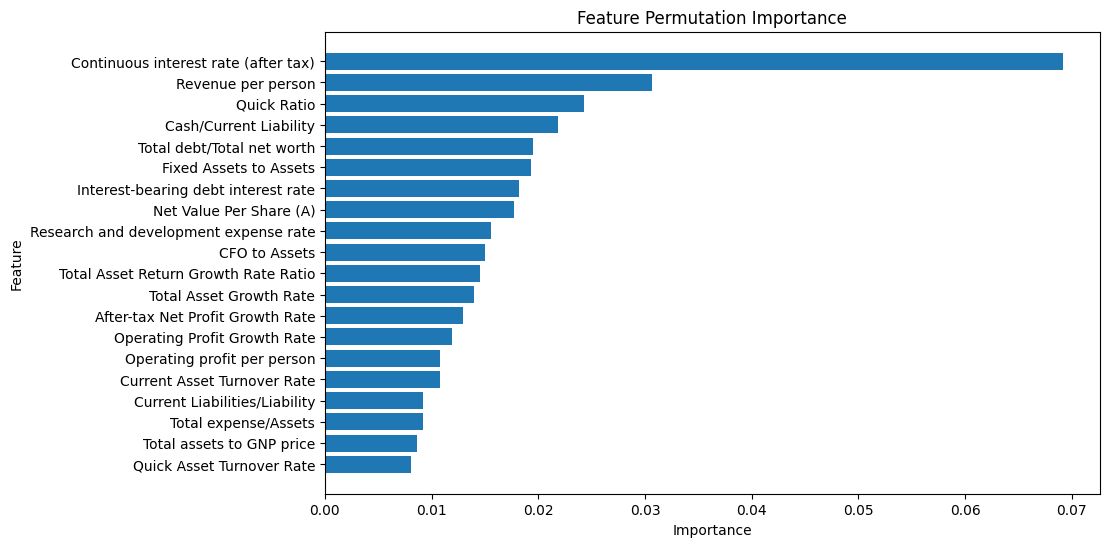

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Original feat removed so far:  ['Continuous interest rate (after tax)']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Revenue per person', 'Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Revenue per person', 'Quick Ratio', 'Cash/Current Liability']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Revenue per person', 'Quick Ratio', 'Cash/Current Liability', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Fixed Assets to Assets
Original feat removed so far:  [

In [ ]:
gbt_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   21  1286  34  23      38.18   47.73        97.42     95.82     42.42   
1    3  1310  10  41      23.08    6.82        99.24     96.26     10.53   
2    3  1311   9  41      25.00    6.82        99.32     96.33     10.71   
3    0  1315   5  44       0.00    0.00        99.62     96.41      0.00   
4    4  1315   5  40      44.44    9.09        99.62     96.70     15.09   
5    0  1318   2  44       0.00    0.00        99.85     96.63      0.00   
6    0  1319   1  44       0.00    0.00        99.92     96.70      0.00   
7    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               72.58                 0   
1               53.03                 1   
2               53.07                 2   
3               49.81                 3   
4               54.36                 4   
5               49.92                 5   
6               49.96                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Reve...  
3   ['Continuous interest rate (after tax)', 'Reve...  
4   ['Continuous interest rate (after tax)', 'Reve...  
5   ['Continuous interest rate (after tax)', 'Reve...  
6   ['Continuous interest rate (after tax)', 'Reve...  
7   ['Continuous interest rate (after tax)', 'Reve...  
8   ['Continuous interest rate (after tax)', 'Reve...  
9   ['Continuous interest rate (after tax)', 'Reve...  
10  ['Continuous interest rate (after tax)', 'Reve...  
11  ['Continuous interest rate (after tax)', 'Reve...  
12  ['Continuous interest rate (after tax)', 'Reve...  
13  ['Continuous interest rate (after tax)', 'Reve...  
14  ['Continuous interest rate (after tax)', 'Reve...  
15  ['Continuous interest rate (after tax)', 'Reve...  
16  ['Continuous interest rate (after tax)', 'Reve...  
17  ['Continuous interest rate (after tax)', 'Reve...  
18  ['Continuous interest rate (after tax)', 'Reve...  
19  ['Continuous interest rate (after tax)', 'Reve...  
20  ['Continuous interest rate (after tax)', 'Reve...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 16:08:56.397321

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Asse

In [ ]:
gbt_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   21  1286  34  23      38.18   47.73        97.42     95.82     42.42   
1   22  1286  34  22      39.29   50.00        97.42     95.89     44.00   
2   22  1284  36  22      37.93   50.00        97.27     95.75     43.14   
3   14  1306  14  30      50.00   31.82        98.94     96.77     38.89   
4   16  1304  16  28      50.00   36.36        98.79     96.77     42.11   
5   16  1304  16  28      50.00   36.36        98.79     96.77     42.11   
6   15  1303  17  29      46.88   34.09        98.71     96.63     39.47   
7   16  1301  19  28      45.71   36.36        98.56     96.55     40.51   
8   14  1298  22  30      38.89   31.82        98.33     96.19     35.00   
9   18  1296  24  26      42.86   40.91        98.18     96.33     41.86   
10  18  1296  24  26      42.86   40.91        98.18     96.33     41.86   
11  16  1301  19  28      45.71   36.36        98.56     96.55     40.51   
12  16  1296  24  28      40.00   36.36        98.18     96.19     38.10   
13  20  1297  23  24      46.51   45.45        98.26     96.55     45.98   
14  19  1301  19  25      50.00   43.18        98.56     96.77     46.34   
15  20  1297  23  24      46.51   45.45        98.26     96.55     45.98   
16  21  1299  21  23      50.00   47.73        98.41     96.77     48.84   
17  22  1300  20  22      52.38   50.00        98.48     96.92     51.16   
18  20  1298  22  24      47.62   45.45        98.33     96.63     46.51   
19  22  1297  23  22      48.89   50.00        98.26     96.70     49.44   
20  21  1287  33  23      38.89   47.73        97.50     95.89     42.86   

    balanced_accuracy  num_feat_missing  \
0               72.58                 0   
1               73.71                 1   
2               73.64                 2   
3               65.38                 3   
4               67.58                 4   
5               67.58                 5   
6               66.40                 6   
7               67.46                 7   
8               65.08                 8   
9               69.55                 9   
10              69.55                10   
11              67.46                11   
12              67.27                12   
13              71.86                13   
14              70.87                14   
15              71.86                15   
16              73.07                16   
17              74.24                17   
18              71.89                18   
19              74.13                19   
20              72.61                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Reve...  
3   ['Continuous interest rate (after tax)', 'Reve...  
4   ['Continuous interest rate (after tax)', 'Reve...  
5   ['Continuous interest rate (after tax)', 'Reve...  
6   ['Continuous interest rate (after tax)', 'Reve...  
7   ['Continuous interest rate (after tax)', 'Reve...  
8   ['Continuous interest rate (after tax)', 'Reve...  
9   ['Continuous interest rate (after tax)', 'Reve...  
10  ['Continuous interest rate (after tax)', 'Reve...  
11  ['Continuous interest rate (after tax)', 'Reve...  
12  ['Continuous interest rate (after tax)', 'Reve...  
13  ['Continuous interest rate (after tax)', 'Reve...  
14  ['Continuous interest rate (after tax)', 'Reve...  
15  ['Continuous interest rate (after tax)', 'Reve...  
16  ['Continuous interest rate (after tax)', 'Reve...  
17  ['Continuous interest rate (after tax)', 'Reve...  
18  ['Continuous interest rate (after tax)', 'Reve...  
19  ['Continuous interest rate (after tax)', 'Reve...  
20  ['Continuous interest rate (after tax)', 'Reve...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10, 5, 1, 0.5, 0],           # L2 regularization on weights
      'gamma': [1, 0.5, 0.1, 0.05, 0.0],         # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb_param_grid = {
      'n_estimators': [100],
      'max_depth': [None],
      'reg_lambda':[10.0],
      'gamma': [0.5],
      'colsample_bytree':[0.75]
  }

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 16:16:58.129554

Nested Cross-validation Results:
Individual scores: [0.57894737 0.484375   0.42477876]
Average nested CV score: 0.496 (+/- 0.127)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.75, 'gamma': 0.5, 'max_depth': None, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.496
2025-01-16 16:17:03.888001

Execution time: 0.10 minutes


```
Starting hyperparameter tuning at: 2025-01-13 01:49:33.193290

Nested Cross-validation Results:
Individual scores: [0.275      0.39506173 0.44186047]
Average nested CV score: 0.371 (+/- 0.141)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0}

Best Model Performance:
Best CV score: 0.448
2025-01-13 02:09:56.878399

Execution time: 20.39 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 18:50:35.252808

Nested Cross-validation Results:
Individual scores: [0.43636364 0.48120301 0.44262295]
Average nested CV score: 0.453 (+/- 0.040)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.75, 'gamma': 0.5, 'max_depth': None, 'n_estimators': 100, 'reg_lambda': 10}

Best Model Performance:
Best CV score: 0.496
2025-01-15 19:11:17.953417

Execution time: 20.71 minutes
```



In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
48      Interest-bearing debt interest rate    0.039362  0.003466
40                       Revenue per person    0.028684  0.003646
34                  Total Asset Growth Rate    0.013449  0.002068
21                   Cash/Current Liability    0.012322  0.004831
46               Total debt/Total net worth    0.011325  0.001792
6      Continuous interest rate (after tax)    0.010878  0.003345
35                   Fixed Assets to Assets    0.009552  0.003777
45                Quick Asset Turnover Rate    0.006770  0.001372
58               Revenue Per Share (Yuan ¥)    0.005647  0.001777
42    Research and development expense rate    0.003960  0.001380
17                            CFO to Assets    0.003931  0.005492
56                  Average Collection Days    0.003396  0.001127
50            Current Liabilities/Liability    0.002833  0.000000
44                              Quick Ratio    0.002830  0.001787
31          Fixed Assets Turnover Frequency    0.002830  0.001787
20                     Total expense/Assets    0.002266  0.001133
5                   Net Value Per Share (A)    0.002263  0.002115
37             Operating Profit Growth Rate    0.001700  0.001388
23                        Cash/Total Assets    0.001700  0.001388
22     Total Asset Return Growth Rate Ratio    0.001700  0.001388
16                   Interest Expense Ratio    0.001133  0.001388
36                    Net Value Growth Rate    0.001133  0.001388
7                    Working Capital/Equity    0.001133  0.001388
53              Current Asset Turnover Rate    0.001133  0.001388
27                      Cash Flow to Equity    0.000567  0.001133
30         Contingent liabilities/Net worth    0.000567  0.001133
41  Realized Sales Gross Profit Growth Rate    0.000567  0.001133
43                       Cash Turnover Rate    0.000567  0.001133
9               Operating profit per person    0.000567  0.001133
52                   Operating Expense Rate    0.000567  0.001133

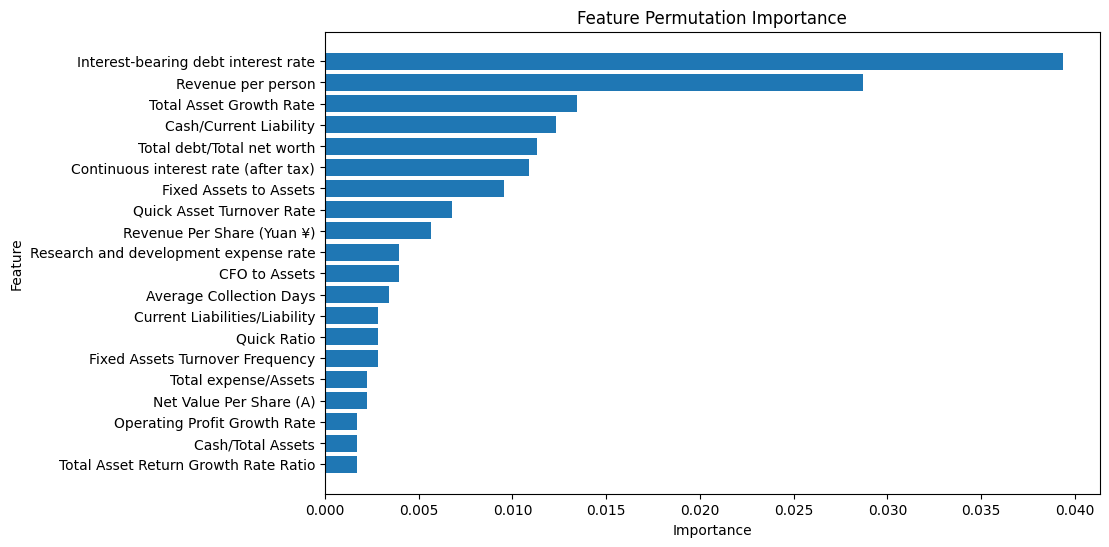

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Total Asset Growth Rate
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Total Asset Growth Rate']

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Total Asset Growth Rate', 'Cash/Current Liability']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Total Asset Growth Rate', 'Cash/Current Liability', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Continuous in

In [ ]:
xgb_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1297  23  22      48.89   50.00        98.26     96.70     49.44   
1   16  1304  16  28      50.00   36.36        98.79     96.77     42.11   
2   15  1303  17  29      46.88   34.09        98.71     96.63     39.47   
3   12  1307  13  32      48.00   27.27        99.02     96.70     34.78   
4   17  1302  18  27      48.57   38.64        98.64     96.70     43.04   
5    9  1314   6  35      60.00   20.45        99.55     96.99     30.51   
6    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
7    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               74.13                 0   
1               67.58                 1   
2               66.40                 2   
3               63.14                 3   
4               68.64                 4   
5               60.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Reven...  
3   ['Interest-bearing debt interest rate', 'Reven...  
4   ['Interest-bearing debt interest rate', 'Reven...  
5   ['Interest-bearing debt interest rate', 'Reven...  
6   ['Interest-bearing debt interest rate', 'Reven...  
7   ['Interest-bearing debt interest rate', 'Reven...  
8   ['Interest-bearing debt interest rate', 'Reven...  
9   ['Interest-bearing debt interest rate', 'Reven...  
10  ['Interest-bearing debt interest rate', 'Reven...  
11  ['Interest-bearing debt interest rate', 'Reven...  
12  ['Interest-bearing debt interest rate', 'Reven...  
13  ['Interest-bearing debt interest rate', 'Reven...  
14  ['Interest-bearing debt interest rate', 'Reven...  
15  ['Interest-bearing debt interest rate', 'Reven...  
16  ['Interest-bearing debt interest rate', 'Reven...  
17  ['Interest-bearing debt interest rate', 'Reven...  
18  ['Interest-bearing debt interest rate', 'Reven...  
19  ['Interest-bearing debt interest rate', 'Reven...  
20  ['Interest-bearing debt interest rate', 'Reven...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 16:17:08.017733

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Asset

In [ ]:
xgb_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1297  23  22      48.89   50.00        98.26     96.70     49.44   
1   22  1288  32  22      40.74   50.00        97.58     96.04     44.90   
2   23  1288  32  21      41.82   52.27        97.58     96.11     46.46   
3   24  1288  32  20      42.86   54.55        97.58     96.19     48.00   
4   27  1281  39  17      40.91   61.36        97.05     95.89     49.09   
5   26  1277  43  18      37.68   59.09        96.74     95.53     46.02   
6   27  1276  44  17      38.03   61.36        96.67     95.53     46.96   
7   28  1271  49  16      36.36   63.64        96.29     95.23     46.28   
8   27  1268  52  17      34.18   61.36        96.06     94.94     43.90   
9   28  1268  52  16      35.00   63.64        96.06     95.01     45.16   
10  27  1265  55  17      32.93   61.36        95.83     94.72     42.86   
11  28  1264  56  16      33.33   63.64        95.76     94.72     43.75   
12  28  1266  54  16      34.15   63.64        95.91     94.87     44.44   
13  28  1266  54  16      34.15   63.64        95.91     94.87     44.44   
14  21  1281  39  23      35.00   47.73        97.05     95.45     40.38   
15  22  1280  40  22      35.48   50.00        96.97     95.45     41.51   
16  22  1278  42  22      34.38   50.00        96.82     95.31     40.74   
17  22  1284  36  22      37.93   50.00        97.27     95.75     43.14   
18  23  1288  32  21      41.82   52.27        97.58     96.11     46.46   
19  23  1281  39  21      37.10   52.27        97.05     95.60     43.40   
20  20  1288  32  24      38.46   45.45        97.58     95.89     41.67   

    balanced_accuracy  num_feat_missing  \
0               74.13                 0   
1               73.79                 1   
2               74.92                 2   
3               76.06                 3   
4               79.20                 4   
5               77.92                 5   
6               79.02                 6   
7               79.96                 7   
8               78.71                 8   
9               79.85                 9   
10              78.60                10   
11              79.70                11   
12              79.77                12   
13              79.77                13   
14              72.39                14   
15              73.48                15   
16              73.41                16   
17              73.64                17   
18              74.92                18   
19              74.66                19   
20              71.52                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Reven...  
3   ['Interest-bearing debt interest rate', 'Reven...  
4   ['Interest-bearing debt interest rate', 'Reven...  
5   ['Interest-bearing debt interest rate', 'Reven...  
6   ['Interest-bearing debt interest rate', 'Reven...  
7   ['Interest-bearing debt interest rate', 'Reven...  
8   ['Interest-bearing debt interest rate', 'Reven...  
9   ['Interest-bearing debt interest rate', 'Reven...  
10  ['Interest-bearing debt interest rate', 'Reven...  
11  ['Interest-bearing debt interest rate', 'Reven...  
12  ['Interest-bearing debt interest rate', 'Reven...  
13  ['Interest-bearing debt interest rate', 'Reven...  
14  ['Interest-bearing debt interest rate', 'Reven...  
15  ['Interest-bearing debt interest rate', 'Reven...  
16  ['Interest-bearing debt interest rate', 'Reven...  
17  ['Interest-bearing debt interest rate', 'Reven...  
18  ['Interest-bearing debt interest rate', 'Reven...  
19  ['Interest-bearing debt interest rate', 'Reven...  
20  ['Interest-bearing debt interest rate', 'Reven...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et_param_grid = {
      'n_estimators': [200],
      'max_depth': [None],
      'max_features':[0.5],
      'min_samples_split': [0.005],
      'min_samples_leaf': [0.001]
  }

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 16:25:10.538822

Nested Cross-validation Results:
Individual scores: [0.56521739 0.49382716 0.41538462]
Average nested CV score: 0.491 (+/- 0.122)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.491
2025-01-16 16:25:20.654012

Execution time: 0.17 minutes




```
Starting hyperparameter tuning at: 2025-01-15 19:11:17.964904

Nested Cross-validation Results:
Individual scores: [0.50632911 0.38735178 0.4295302 ]
Average nested CV score: 0.441 (+/- 0.099)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.491
2025-01-15 19:33:43.144831

Execution time: 22.42 minutes
```



In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
31                    Fixed Assets Turnover Frequency  3.420633e-03  0.001787
43                                 Cash Turnover Rate  3.168813e-03  0.002938
57                        Inventory/Current Liability  2.444083e-03  0.002041
29                               Total Asset Turnover  2.443169e-03  0.002184
49                    Inventory Turnover Rate (times)  1.704815e-03  0.002855
50                      Current Liabilities/Liability  1.464769e-03  0.002250
58                         Revenue Per Share (Yuan ¥)  9.810915e-04  0.000917
42              Research and development expense rate  9.810915e-04  0.000917
40                                 Revenue per person  9.792577e-04  0.001431
30                   Contingent liabilities/Net worth  7.365044e-04  0.000601
53                        Current Asset Turnover Rate  7.328470e-04  0.001661
38                  Continuous Net Profit Growth Rate -9.194811e-07  0.000778
41            Realized Sales Gross Profit Growth Rate -1.838962e-06  0.001100
54              Long-term Liability to Current Assets -2.464209e-04  0.000493
35                             Fixed Assets to Assets -2.491846e-04  0.001436
22               Total Asset Return Growth Rate Ratio -4.937614e-04  0.000984
47                          Total assets to GNP price -4.955952e-04  0.001473
52                             Operating Expense Rate -9.884526e-04  0.001437
7                              Working Capital/Equity -9.884526e-04  0.001437
55                       Accounts Receivable Turnover -1.233954e-03  0.001104
25                          Inventory/Working Capital -1.235798e-03  0.001559
18  Interest Coverage Ratio (Interest expense to E... -1.235803e-03  0.001561
37                       Operating Profit Growth Rate -1.240437e-03  0.002345
45                          Quick Asset Turnover Rate -1.479450e-03  0.000495
48                Interest-bearing debt interest rate -1.493295e-03  0.003057
21                             Cash/Current Liability -1.975996e-03  0.001261
24                   After-tax Net Profit Growth Rate -2.221487e-03  0.000495
26                                 No-credit Interval -2.469763e-03  0.000784
39               Long-term fund suitability ratio (A) -2.477191e-03  0.002348
56                            Average Collection Days -2.722693e-03  0.001984
27                                Cash Flow to Equity -2.967249e-03  0.001266
10                      Equity to Long-term Liability -2.978407e-03  0.002994
51                         Allocation rate per person -3.462870e-03  0.000930
16                             Interest Expense Ratio -3.471239e-03  0.002525
33                 Degree of Financial Leverage (DFL) -3.711145e-03  0.000787
28                          Quick Assets/Total Assets -3.717707e-03  0.002230
19        Inventory and accounts receivable/Net value -3.961296e-03  0.001221
32                             Cash Flow to Liability -5.208300e-03  0.001226
15                             Operating Gross Margin -5.466018e-03  0.002582
36                              Net Value Growth Rate -5.959710e-03  0.001464
9                         Operating profit per person -6.709212e-03  0.000615
20                               Total expense/Assets -7.469155e-03  0.002103
34                            Total Asset Growth Rate -9.023759e-03  0.005829
17                                      CFO to Assets -9.256777e-03  0.004386
60                                      Current Ratio -1.075351e-02  0.001718
6                Continuous interest rate (after tax) -1.304895e-02  0.001912
59                     Quick Assets/Current Liability -1.433049e-02  0.001926
4                 Current Liability to Current Assets -1.538063e-02  0.004253
23                                  Cash/Total Assets -1.542250e-02  0.006827
8                 Operating Profit Per Share (Yuan ¥) -2.029857e-02  0.003207
3                          Current Liabilities/Equity -2.186576e-02 

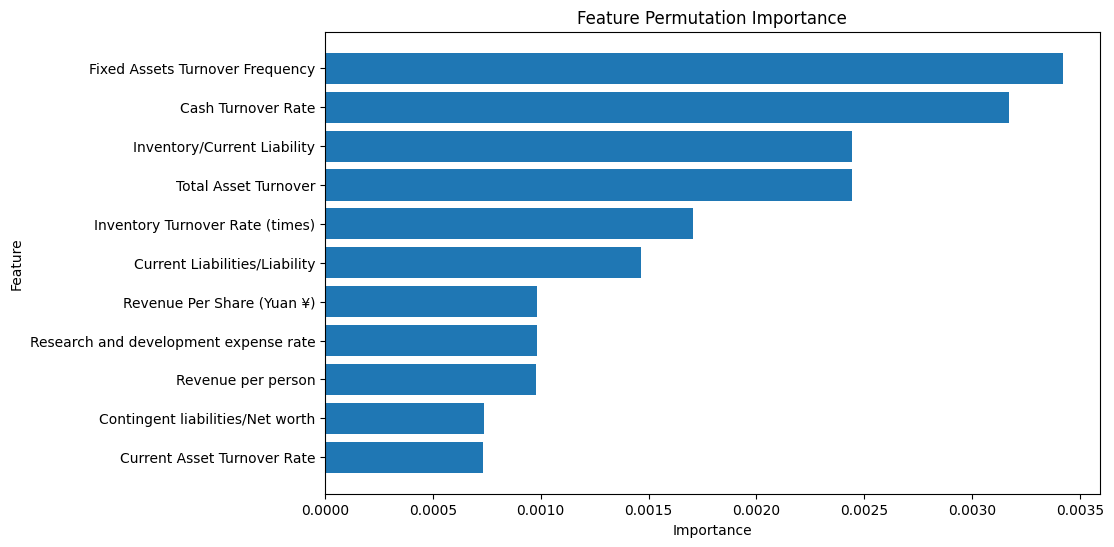

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Fixed Assets Turnover Frequency
Original feat removed so far:  ['Fixed Assets Turnover Frequency']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Fixed Assets Turnover Frequency', 'Cash Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Inventory/Current Liability
Original feat removed so far:  ['Fixed Assets Turnover Frequency', 'Cash Turnover Rate', 'Inventory/Current Liability']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Fixed Assets Turnover Frequency', 'Cash Turnover Rate', 'Inventory/Current Liability', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Inventory Turnover Rate (times)
Original feat removed so far:  ['Fixed Assets Turnover Frequency', 'Cash Turnover Rate', 'Inventory/Current Liability', 'Total Asset Turnover', 'Inventory Turnover Rate (times)']

--- NEW ITERATION ---
Removing feature:  Current Liabiliti

In [ ]:
et_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   28  1262  58  16      32.56   63.64        95.61     94.57     43.08   
1   26  1265  55  18      32.10   59.09        95.83     94.65     41.60   
2   28  1266  54  16      34.15   63.64        95.91     94.87     44.44   
3   29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
4   27  1265  55  17      32.93   61.36        95.83     94.72     42.86   
5   27  1266  54  17      33.33   61.36        95.91     94.79     43.20   
6   27  1262  58  17      31.76   61.36        95.61     94.50     41.86   
7   27  1261  59  17      31.40   61.36        95.53     94.43     41.54   
8   28  1260  60  16      31.82   63.64        95.45     94.43     42.42   
9   28  1259  61  16      31.46   63.64        95.38     94.35     42.11   
10  28  1260  60  16      31.82   63.64        95.45     94.43     42.42   
11  28  1258  62  16      31.11   63.64        95.30     94.28     41.79   
12  28  1258  62  16      31.11   63.64        95.30     94.28     41.79   
13  28  1258  62  16      31.11   63.64        95.30     94.28     41.79   
14  28  1258  62  16      31.11   63.64        95.30     94.28     41.79   
15  27  1258  62  17      30.34   61.36        95.30     94.21     40.60   
16  27  1257  63  17      30.00   61.36        95.23     94.13     40.30   
17  27  1258  62  17      30.34   61.36        95.30     94.21     40.60   
18  27  1260  60  17      31.03   61.36        95.45     94.35     41.22   
19  27  1259  61  17      30.68   61.36        95.38     94.28     40.91   
20  27  1260  60  17      31.03   61.36        95.45     94.35     41.22   

    balanced_accuracy  num_feat_missing  \
0               79.62                 0   
1               77.46                 1   
2               79.77                 2   
3               80.87                 3   
4               78.60                 4   
5               78.64                 5   
6               78.48                 6   
7               78.45                 7   
8               79.55                 8   
9               79.51                 9   
10              79.55                10   
11              79.47                11   
12              79.47                12   
13              79.47                13   
14              79.47                14   
15              78.33                15   
16              78.30                16   
17              78.33                17   
18              78.41                18   
19              78.37                19   
20              78.41                20   

                                              imputed  
0                                                      
1         ['Fixed Assets Turnover Frequency'] imputed  
2   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
3   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
4   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
5   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
6   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
7   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
8   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
9   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
10  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
11  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
12  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
13  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
14  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
15  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
16  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
17  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
18  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
19  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
20  ['Fixed Assets Turnover Frequency', 'Cash Turn...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 16:25:32.121797

--- NEW ITERATION ---
Removing feature:  Fixed Assets Turnover Frequency
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Assets', 

In [ ]:
et_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   28  1262  58  16      32.56   63.64        95.61     94.57     43.08   
1   28  1264  56  16      33.33   63.64        95.76     94.72     43.75   
2   28  1261  59  16      32.18   63.64        95.53     94.50     42.75   
3   28  1263  57  16      32.94   63.64        95.68     94.65     43.41   
4   28  1261  59  16      32.18   63.64        95.53     94.50     42.75   
5   28  1263  57  16      32.94   63.64        95.68     94.65     43.41   
6   28  1263  57  16      32.94   63.64        95.68     94.65     43.41   
7   28  1262  58  16      32.56   63.64        95.61     94.57     43.08   
8   29  1261  59  15      32.95   65.91        95.53     94.57     43.94   
9   29  1259  61  15      32.22   65.91        95.38     94.43     43.28   
10  29  1259  61  15      32.22   65.91        95.38     94.43     43.28   
11  29  1259  61  15      32.22   65.91        95.38     94.43     43.28   
12  29  1259  61  15      32.22   65.91        95.38     94.43     43.28   
13  29  1258  62  15      31.87   65.91        95.30     94.35     42.96   
14  29  1259  61  15      32.22   65.91        95.38     94.43     43.28   
15  29  1257  63  15      31.52   65.91        95.23     94.28     42.65   
16  29  1262  58  15      33.33   65.91        95.61     94.65     44.27   
17  29  1261  59  15      32.95   65.91        95.53     94.57     43.94   
18  29  1262  58  15      33.33   65.91        95.61     94.65     44.27   
19  29  1263  57  15      33.72   65.91        95.68     94.72     44.62   
20  29  1262  58  15      33.33   65.91        95.61     94.65     44.27   

    balanced_accuracy  num_feat_missing  \
0               79.62                 0   
1               79.70                 1   
2               79.58                 2   
3               79.66                 3   
4               79.58                 4   
5               79.66                 5   
6               79.66                 6   
7               79.62                 7   
8               80.72                 8   
9               80.64                 9   
10              80.64                10   
11              80.64                11   
12              80.64                12   
13              80.61                13   
14              80.64                14   
15              80.57                15   
16              80.76                16   
17              80.72                17   
18              80.76                18   
19              80.80                19   
20              80.76                20   

                                              imputed  
0                                                      
1         ['Fixed Assets Turnover Frequency'] imputed  
2   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
3   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
4   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
5   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
6   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
7   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
8   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
9   ['Fixed Assets Turnover Frequency', 'Cash Turn...  
10  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
11  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
12  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
13  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
14  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
15  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
16  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
17  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
18  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
19  ['Fixed Assets Turnover Frequency', 'Cash Turn...  
20  ['Fixed Assets Turnover Frequency', 'Cash Turn...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, taiwan_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = taiwan_scaler)

In [ ]:
taiwan_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm_param_grid = {
    'C': [10.0],
    'kernel': ['poly'],
    'gamma': [0.5],
    'degree': [3]
}

svm_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 3, 3, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-16 16:33:33.633129

Nested Cross-validation Results:
Individual scores: [0.36082474 0.24137931 0.31683168]
Average nested CV score: 0.306 (+/- 0.099)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 10.0, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.306
2025-01-16 16:33:41.807464

Execution time: 0.14 minutes




```
Starting hyperparameter tuning at: 2025-01-15 19:33:43.187891

Nested Cross-validation Results:
Individual scores: [0.32631579 0.22222222 0.28837209]
Average nested CV score: 0.279 (+/- 0.086)

Fitting final model on entire dataset...
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best parameters: {'C': 10, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.306
2025-01-15 19:40:12.098708

Execution time: 6.48 minutes
```



In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1")
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
29                               Total Asset Turnover    0.195997  0.010109
28                          Quick Assets/Total Assets    0.150153  0.012508
11                                Equity to Liability    0.131634  0.012169
50                      Current Liabilities/Liability    0.098562  0.007957
45                          Quick Asset Turnover Rate    0.087049  0.008049
43                                 Cash Turnover Rate    0.069899  0.011518
23                                  Cash/Total Assets    0.068581  0.017879
31                    Fixed Assets Turnover Frequency    0.058982  0.004902
42              Research and development expense rate    0.055234  0.007489
49                    Inventory Turnover Rate (times)    0.053113  0.008174
53                        Current Asset Turnover Rate    0.051137  0.007299
34                            Total Asset Growth Rate    0.047398  0.014906
20                               Total expense/Assets    0.044144  0.002992
52                             Operating Expense Rate    0.039529  0.005124
12                                       Tax rate (A)    0.023124  0.009512
17                                      CFO to Assets    0.015890  0.007196
14                              Liability-Assets Flag    0.012143  0.001318
57                        Inventory/Current Liability    0.009489  0.001651
32                             Cash Flow to Liability    0.009305  0.002841
2                   Retained Earnings to Total Assets    0.008999  0.002338
27                                Cash Flow to Equity    0.008668  0.002222
7                              Working Capital/Equity    0.008153  0.002180
3                          Current Liabilities/Equity    0.006179  0.001521
46                         Total debt/Total net worth    0.005783  0.000377
21                             Cash/Current Liability    0.005417  0.000970
4                 Current Liability to Current Assets    0.005163  0.003685
54              Long-term Liability to Current Assets    0.004957  0.002515
25                          Inventory/Working Capital    0.004545  0.001546
33                 Degree of Financial Leverage (DFL)    0.004350  0.001821
47                          Total assets to GNP price    0.004043  0.001393
48                Interest-bearing debt interest rate    0.003458  0.004053
9                         Operating profit per person    0.003287  0.002406
24                   After-tax Net Profit Growth Rate    0.002953  0.001136
35                             Fixed Assets to Assets    0.002687  0.000382
16                             Interest Expense Ratio    0.002468  0.001097
40                                 Revenue per person    0.002375  0.000312
26                                 No-credit Interval    0.001715  0.000582
55                       Accounts Receivable Turnover    0.001533  0.001734
37                       Operating Profit Growth Rate    0.001404  0.000311
18  Interest Coverage Ratio (Interest expense to E...    0.001244  0.001600
44                                        Quick Ratio    0.001093  0.000381
38                  Continuous Net Profit Growth Rate    0.000781  0.000000
6                Continuous interest rate (after tax)    0.000781  0.000000
30                   Contingent liabilities/Net worth    0.000625  0.000312
5                             Net Value Per Share (A)    0.000523  0.009175
13                         Total income/Total expense   -0.000157  0.000313
41            Realized Sales Gross Profit Growth Rate   -0.000157  0.000313
56                            Average Collection Days   -0.000314  0.000799
39               Long-term fund suitability ratio (A)   -0.001571  0.000997
22               Total Asset Return Growth Rate Ratio   -0.001728  0.000919
19        Inventory and accounts receivable/Net value   -0.002998  0.002089
8                 Operating Profit Per Share (Yuan ¥)   -0.004300  0.002021
0                 

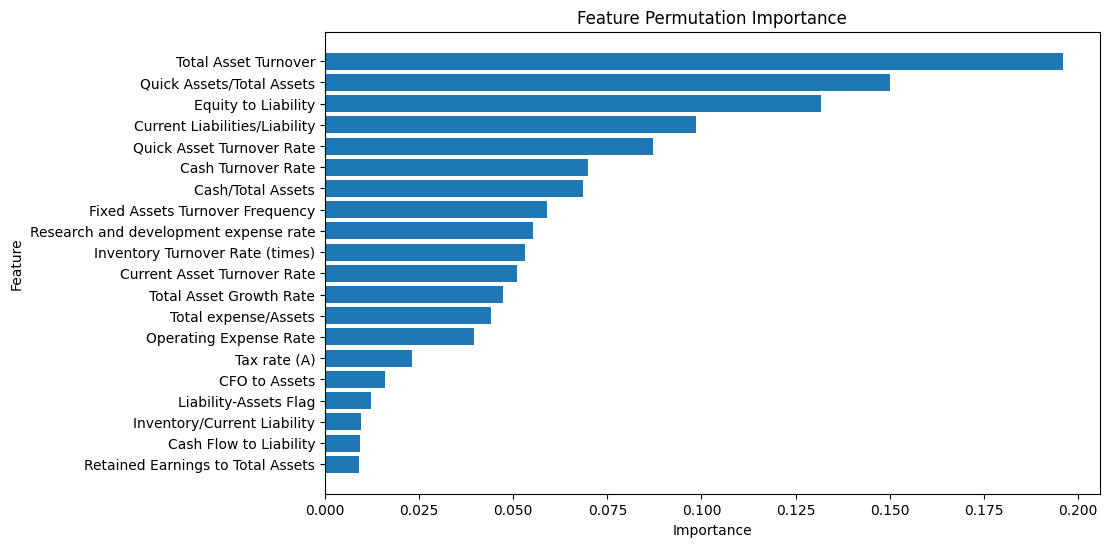

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    taiwan_imputation_scaled_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Original feat removed so far:  ['Total Asset Turnover', 'Quick Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Total Asset Turnover', 'Quick Assets/Total Assets', 'Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Current Liabilities/Liability
Original feat removed so far:  ['Total Asset Turnover', 'Quick Assets/Total Assets', 'Equity to Liability', 'Current Liabilities/Liability']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Total Asset Turnover', 'Quick Assets/Total Assets', 'Equity to Liability', 'Current Liabilities/Liability', 'Quick Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Total Asset T

In [ ]:
svm_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   26  1227   93  18      21.85   59.09        92.95     91.86     31.90   
1   27  1202  118  17      18.62   61.36        91.06     90.10     28.57   
2   28  1176  144  16      16.28   63.64        89.09     88.27     25.93   
3   22  1206  114  22      16.18   50.00        91.36     90.03     24.44   
4   26  1180  140  18      15.66   59.09        89.39     88.42     24.76   
5   24  1151  169  20      12.44   54.55        87.20     86.14     20.25   
6   26  1080  240  18       9.77   59.09        81.82     81.09     16.77   
7   26  1100  220  18      10.57   59.09        83.33     82.55     17.93   
8   28  1083  237  16      10.57   63.64        82.05     81.45     18.12   
9   30  1041  279  14       9.71   68.18        78.86     78.52     17.00   
10  30  1004  316  14       8.67   68.18        76.06     75.81     15.38   
11  28  1077  243  16      10.33   63.64        81.59     81.01     17.78   
12  25  1038  282  19       8.14   56.82        78.64     77.93     14.25   
13  25  1090  230  19       9.80   56.82        82.58     81.74     16.72   
14  28  1111  209  16      11.81   63.64        84.17     83.50     19.93   
15  19  1151  169  25      10.11   43.18        87.20     85.78     16.38   
16  16  1166  154  28       9.41   36.36        88.33     86.66     14.95   
17  15  1166  154  29       8.88   34.09        88.33     86.58     14.08   
18  15  1164  156  29       8.77   34.09        88.18     86.44     13.95   
19  15  1173  147  29       9.26   34.09        88.86     87.10     14.56   
20  17  1147  173  27       8.95   38.64        86.89     85.34     14.53   

    balanced_accuracy  num_feat_missing  \
0               76.02                 0   
1               76.21                 1   
2               76.36                 2   
3               70.68                 3   
4               74.24                 4   
5               70.87                 5   
6               70.45                 6   
7               71.21                 7   
8               72.84                 8   
9               73.52                 9   
10              72.12                10   
11              72.61                11   
12              67.73                12   
13              69.70                13   
14              73.90                14   
15              65.19                15   
16              62.35                16   
17              61.21                17   
18              61.14                18   
19              61.48                19   
20              62.77                20   

                                              imputed  
0                                                      
1                    ['Total Asset Turnover'] imputed  
2   ['Total Asset Turnover', 'Quick Assets/Total A...  
3   ['Total Asset Turnover', 'Quick Assets/Total A...  
4   ['Total Asset Turnover', 'Quick Assets/Total A...  
5   ['Total Asset Turnover', 'Quick Assets/Total A...  
6   ['Total Asset Turnover', 'Quick Assets/Total A...  
7   ['Total Asset Turnover', 'Quick Assets/Total A...  
8   ['Total Asset Turnover', 'Quick Assets/Total A...  
9   ['Total Asset Turnover', 'Quick Assets/Total A...  
10  ['Total Asset Turnover', 'Quick Assets/Total A...  
11  ['Total Asset Turnover', 'Quick Assets/Total A...  
12  ['Total Asset Turnover', 'Quick Assets/Total A...  
13  ['Total Asset Turnover', 'Quick Assets/Total A...  
14  ['Total Asset Turnover', 'Quick Assets/Total A...  
15  ['Total Asset Turnover', 'Quick Assets/Total A...  
16  ['Total Asset Turnover', 'Quick Assets/Total A...  
17  ['Total Asset Turnover', 'Quick Assets/Total A...  
18  ['Total Asset Turnover', 'Quick Assets/Total A...  
19  ['Total Asset Turnover', 'Quick Assets/Total A...  
20  ['Total Asset Turnover', 'Quick Assets/Total A...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 16:34:04.985310

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Assets', 'Total Asse

In [ ]:
svm_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   26  1227   93  18      21.85   59.09        92.95     91.86     31.90   
1   25  1230   90  19      21.74   56.82        93.18     92.01     31.45   
2   25  1215  105  19      19.23   56.82        92.05     90.91     28.74   
3   25  1228   92  19      21.37   56.82        93.03     91.86     31.06   
4   25  1218  102  19      19.69   56.82        92.27     91.13     29.24   
5   30  1183  137  14      17.96   68.18        89.62     88.93     28.44   
6   30  1192  128  14      18.99   68.18        90.30     89.59     29.70   
7   30  1202  118  14      20.27   68.18        91.06     90.32     31.25   
8   30  1195  125  14      19.35   68.18        90.53     89.81     30.15   
9   31  1188  132  13      19.02   70.45        90.00     89.37     29.95   
10  35  1142  178   9      16.43   79.55        86.52     86.29     27.24   
11  38  1047  273   6      12.22   86.36        79.32     79.55     21.41   
12  40   997  323   4      11.02   90.91        75.53     76.03     19.66   
13  38  1008  312   6      10.86   86.36        76.36     76.69     19.29   
14  40   916  404   4       9.01   90.91        69.39     70.09     16.39   
15  40   933  387   4       9.37   90.91        70.68     71.33     16.99   
16  41   947  373   3       9.90   93.18        71.74     72.43     17.90   
17  40   947  373   4       9.69   90.91        71.74     72.36     17.51   
18  40   955  365   4       9.88   90.91        72.35     72.95     17.82   
19  40   947  373   4       9.69   90.91        71.74     72.36     17.51   
20  40   947  373   4       9.69   90.91        71.74     72.36     17.51   

    balanced_accuracy  num_feat_missing  \
0               76.02                 0   
1               75.00                 1   
2               74.43                 2   
3               74.92                 3   
4               74.55                 4   
5               78.90                 5   
6               79.24                 6   
7               79.62                 7   
8               79.36                 8   
9               80.23                 9   
10              83.03                10   
11              82.84                11   
12              83.22                12   
13              81.36                13   
14              80.15                14   
15              80.80                15   
16              82.46                16   
17              81.33                17   
18              81.63                18   
19              81.33                19   
20              81.33                20   

                                              imputed  
0                                                      
1                    ['Total Asset Turnover'] imputed  
2   ['Total Asset Turnover', 'Quick Assets/Total A...  
3   ['Total Asset Turnover', 'Quick Assets/Total A...  
4   ['Total Asset Turnover', 'Quick Assets/Total A...  
5   ['Total Asset Turnover', 'Quick Assets/Total A...  
6   ['Total Asset Turnover', 'Quick Assets/Total A...  
7   ['Total Asset Turnover', 'Quick Assets/Total A...  
8   ['Total Asset Turnover', 'Quick Assets/Total A...  
9   ['Total Asset Turnover', 'Quick Assets/Total A...  
10  ['Total Asset Turnover', 'Quick Assets/Total A...  
11  ['Total Asset Turnover', 'Quick Assets/Total A...  
12  ['Total Asset Turnover', 'Quick Assets/Total A...  
13  ['Total Asset Turnover', 'Quick Assets/Total A...  
14  ['Total Asset Turnover', 'Quick Assets/Total A...  
15  ['Total Asset Turnover', 'Quick Assets/Total A...  
16  ['Total Asset Turnover', 'Quick Assets/Total A...  
17  ['Total Asset Turnover', 'Quick Assets/Total A...  
18  ['Total Asset Turnover', 'Quick Assets/Total A...  
19  ['Total Asset Turnover', 'Quick Assets/Total A...  
20  ['Total Asset Turnover', 'Quick Assets/Total A...

##**Logistic Regression**

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicolinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_taiwan_dist_corr = taiwan_dist_corr[present_features]
filtered_taiwan_dist_corr = filtered_taiwan_dist_corr[filtered_taiwan_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_taiwan_dist_corr, 'Target', 0.8)

appended feature:  Net Income to Stockholder's Equity
appended feature:  Borrowing dependency
appended feature:  Retained Earnings to Total Assets
appended feature:  Current Liabilities/Equity
appended feature:  Current Liability to Current Assets
appended feature:  Net Value Per Share (A)
appended feature:  Continuous interest rate (after tax)
appended feature:  Working Capital/Equity
appended feature:  Operating Profit Per Share (Yuan ¥)
appended feature:  Operating profit per person
appended feature:  Equity to Long-term Liability
appended feature:  Equity to Liability
appended feature:  Tax rate (A)
appended feature:  Total income/Total expense
appended feature:  Liability-Assets Flag
appended feature:  Operating Gross Margin
appended feature:  Interest Expense Ratio
appended feature:  CFO to Assets
appended feature:  Interest Coverage Ratio (Interest expense to EBIT)
appended feature:  Inventory and accounts receivable/Net value
appended feature:  Total expense/Assets
appended fea

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]

In [ ]:
print('Nr. features for Logistic Regression: ', len(lr_X_train.columns))

Nr. features for Logistic Regression:  61


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr_param_grid = {
      'C': [5.0],
      'penalty': ['l1'],
      'solver': ['liblinear']
  }

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 3, 3, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 16:40:37.828542

Nested Cross-validation Results:
Individual scores: [0.26666667 0.2739726  0.28125   ]
Average nested CV score: 0.274 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.274
2025-01-16 16:42:01.786474

Execution time: 1.40 minutes




```
Starting hyperparameter tuning at: 2025-01-15 19:40:12.811834

Nested Cross-validation Results:
Individual scores: [0.26210826 0.26478873 0.26582278]
Average nested CV score: 0.264 (+/- 0.003)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.274
2025-01-15 19:42:34.757128

Execution time: 2.37 minutes
```



In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
11                          Equity to Liability  4.506841e-02  0.013072
20                         Total expense/Assets  2.892194e-02  0.001677
32                       Cash Flow to Liability  1.607261e-02  0.003295
50                Current Liabilities/Liability  1.569108e-02  0.001040
29                         Total Asset Turnover  1.475543e-02  0.006745
27                          Cash Flow to Equity  1.425682e-02  0.001337
19  Inventory and accounts receivable/Net value  1.092923e-02  0.001647
43                           Cash Turnover Rate  9.986278e-03  0.005684
28                    Quick Assets/Total Assets  8.490866e-03  0.000652
49              Inventory Turnover Rate (times)  6.627406e-03  0.001948
14                        Liability-Assets Flag  6.508600e-03  0.000292
34                      Total Asset Growth Rate  3.467687e-03  0.001564
46                   Total debt/Total net worth  2.463628e-03  0.000285
52                       Operating Expense Rate  2.408589e-03  0.001545
39         Long-term fund suitability ratio (A)  1.923947e-03  0.000538
55                 Accounts Receivable Turnover  1.381764e-03  0.000463
53                  Current Asset Turnover Rate  1.285594e-03  0.000349
10                Equity to Long-term Liability  1.199659e-03  0.001111
47                    Total assets to GNP price  8.935026e-04  0.000741
33           Degree of Financial Leverage (DFL)  8.273792e-04  0.000220
9                   Operating profit per person  7.146681e-04  0.001113
37                 Operating Profit Growth Rate  6.440970e-04  0.000286
42        Research and development expense rate  4.909561e-04  0.000454
57                  Inventory/Current Liability  4.683829e-04  0.000397
12                                 Tax rate (A)  4.432831e-04  0.002168
58                   Revenue Per Share (Yuan ¥)  2.932353e-04  0.000000
6          Continuous interest rate (after tax)  2.928943e-04  0.000321
16                       Interest Expense Ratio  2.345882e-04  0.000117
26                           No-credit Interval  2.342479e-04  0.000341
40                           Revenue per person  1.759412e-04  0.000144
59               Quick Assets/Current Liability  1.759412e-04  0.000144
25                    Inventory/Working Capital  5.670514e-05  0.000777
24             After-tax Net Profit Growth Rate -1.138778e-07  0.000186
56                      Average Collection Days -2.351580e-04  0.000220
51                   Allocation rate per person -2.939189e-04  0.000186
45                    Quick Asset Turnover Rate -1.163270e-03  0.002589
21                       Cash/Current Liability -1.306852e-03  0.001443
48          Interest-bearing debt interest rate -1.373415e-03  0.001177
17                                CFO to Assets -1.466866e-03  0.002710
15                       Operating Gross Margin -4.319652e-03  0.002251
23                            Cash/Total Assets -4.332644e-03  0.005067
2             Retained Earnings to Total Assets -5.842139e-03  0.001745
31              Fixed Assets Turnover Frequency -6.352030e-03  0.003011
1                          Borrowing dependency -6.908147e-03  0.002194
8           Operating Profit Per Share (Yuan ¥) -1.092085e-02  0.002862
5                       Net Value Per Share (A) -1.549640e-02  0.006989

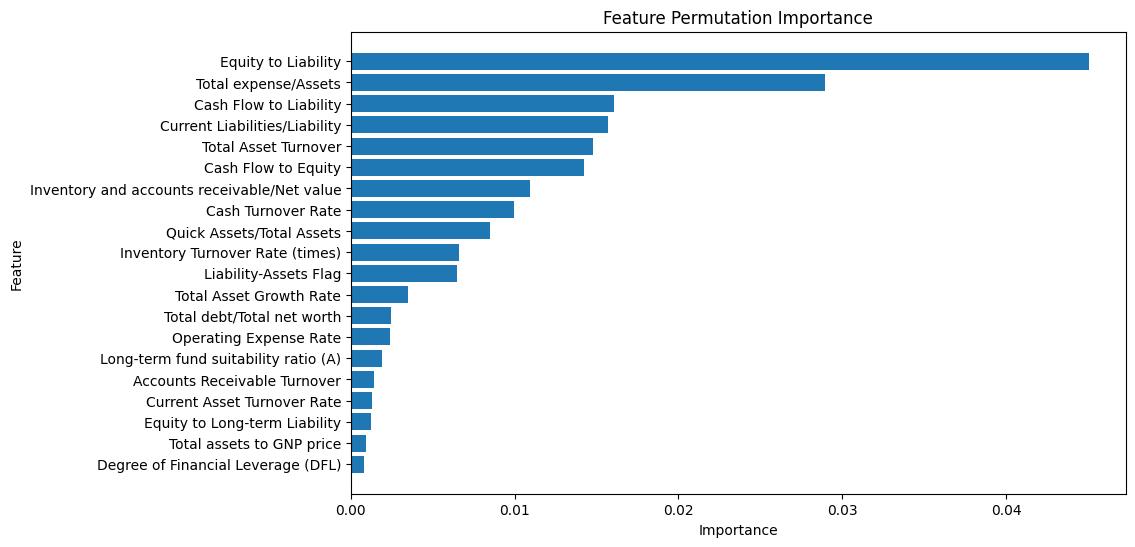

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Total expense/Assets
Original feat removed so far:  ['Equity to Liability', 'Total expense/Assets']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Liability
Original feat removed so far:  ['Equity to Liability', 'Total expense/Assets', 'Cash Flow to Liability']

--- NEW ITERATION ---
Removing feature:  Current Liabilities/Liability
Original feat removed so far:  ['Equity to Liability', 'Total expense/Assets', 'Cash Flow to Liability', 'Current Liabilities/Liability']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Equity to Liability', 'Total expense/Assets', 'Cash Flow to Liability', 'Current Liabilities/Liability', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Equity
Original feat removed so far:  ['Equity to Liability', 'Total expense/Asse

In [ ]:
lr_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1148  172   8      17.31   81.82        86.97     86.80     28.57   
1   33  1149  171  11      16.18   75.00        87.05     86.66     26.61   
2   32  1160  160  12      16.67   72.73        87.88     87.39     27.12   
3   32  1181  139  12      18.71   72.73        89.47     88.93     29.77   
4   34  1165  155  10      17.99   77.27        88.26     87.90     29.18   
5   33  1183  137  11      19.41   75.00        89.62     89.15     30.84   
6   33  1178  142  11      18.86   75.00        89.24     88.78     30.14   
7   34  1166  154  10      18.09   77.27        88.33     87.98     29.31   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               84.39                 0   
1               81.02                 1   
2               80.30                 2   
3               81.10                 3   
4               82.77                 4   
5               82.31                 5   
6               82.12                 6   
7               82.80                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Total expense/Assets'...  
3   ['Equity to Liability', 'Total expense/Assets'...  
4   ['Equity to Liability', 'Total expense/Assets'...  
5   ['Equity to Liability', 'Total expense/Assets'...  
6   ['Equity to Liability', 'Total expense/Assets'...  
7   ['Equity to Liability', 'Total expense/Assets'...  
8   ['Equity to Liability', 'Total expense/Assets'...  
9   ['Equity to Liability', 'Total expense/Assets'...  
10  ['Equity to Liability', 'Total expense/Assets'...  
11  ['Equity to Liability', 'Total expense/Assets'...  
12  ['Equity to Liability', 'Total expense/Assets'...  
13  ['Equity to Liability', 'Total expense/Assets'...  
14  ['Equity to Liability', 'Total expense/Assets'...  
15  ['Equity to Liability', 'Total expense/Assets'...  
16  ['Equity to Liability', 'Total expense/Assets'...  
17  ['Equity to Liability', 'Total expense/Assets'...  
18  ['Equity to Liability', 'Total expense/Assets'...  
19  ['Equity to Liability', 'Total expense/Assets'...  
20  ['Equity to Liability', 'Total expense/Assets'...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 16:42:22.583664

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Assets', 'Total Asset

In [ ]:
lr_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1148  172   8      17.31   81.82        86.97     86.80     28.57   
1   36  1161  159   8      18.46   81.82        87.95     87.76     30.13   
2   35  1157  163   9      17.68   79.55        87.65     87.39     28.93   
3   36  1156  164   8      18.00   81.82        87.58     87.39     29.51   
4   36  1164  156   8      18.75   81.82        88.18     87.98     30.51   
5   34  1164  156  10      17.89   77.27        88.18     87.83     29.06   
6   34  1166  154  10      18.09   77.27        88.33     87.98     29.31   
7   34  1164  156  10      17.89   77.27        88.18     87.83     29.06   
8   35  1172  148   9      19.13   79.55        88.79     88.49     30.84   
9   35  1162  158   9      18.13   79.55        88.03     87.76     29.54   
10  34  1167  153  10      18.18   77.27        88.41     88.05     29.44   
11  34  1167  153  10      18.18   77.27        88.41     88.05     29.44   
12  35  1169  151   9      18.82   79.55        88.56     88.27     30.43   
13  35  1169  151   9      18.82   79.55        88.56     88.27     30.43   
14  35  1160  160   9      17.95   79.55        87.88     87.61     29.29   
15  35  1158  162   9      17.77   79.55        87.73     87.46     29.05   
16  35  1158  162   9      17.77   79.55        87.73     87.46     29.05   
17  35  1158  162   9      17.77   79.55        87.73     87.46     29.05   
18  35  1158  162   9      17.77   79.55        87.73     87.46     29.05   
19  36  1158  162   8      18.18   81.82        87.73     87.54     29.75   
20  36  1160  160   8      18.37   81.82        87.88     87.68     30.00   

    balanced_accuracy  num_feat_missing  \
0               84.39                 0   
1               84.89                 1   
2               83.60                 2   
3               84.70                 3   
4               85.00                 4   
5               82.73                 5   
6               82.80                 6   
7               82.73                 7   
8               84.17                 8   
9               83.79                 9   
10              82.84                10   
11              82.84                11   
12              84.05                12   
13              84.05                13   
14              83.71                14   
15              83.64                15   
16              83.64                16   
17              83.64                17   
18              83.64                18   
19              84.77                19   
20              84.85                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Total expense/Assets'...  
3   ['Equity to Liability', 'Total expense/Assets'...  
4   ['Equity to Liability', 'Total expense/Assets'...  
5   ['Equity to Liability', 'Total expense/Assets'...  
6   ['Equity to Liability', 'Total expense/Assets'...  
7   ['Equity to Liability', 'Total expense/Assets'...  
8   ['Equity to Liability', 'Total expense/Assets'...  
9   ['Equity to Liability', 'Total expense/Assets'...  
10  ['Equity to Liability', 'Total expense/Assets'...  
11  ['Equity to Liability', 'Total expense/Assets'...  
12  ['Equity to Liability', 'Total expense/Assets'...  
13  ['Equity to Liability', 'Total expense/Assets'...  
14  ['Equity to Liability', 'Total expense/Assets'...  
15  ['Equity to Liability', 'Total expense/Assets'...  
16  ['Equity to Liability', 'Total expense/Assets'...  
17  ['Equity to Liability', 'Total expense/Assets'...  
18  ['Equity to Liability', 'Total expense/Assets'...  
19  ['Equity to Liability', 'Total expense/Assets'...  
20  ['Equity to Liability', 'Total expense/Assets'...

# **Models optimized for Balanced Accuracy**

##**Decision tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [4],
      'min_samples_split': [0.10],
      'min_samples_leaf': [0.05]
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(
    dt2_classifier, dt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 16:48:53.351295

Nested Cross-validation Results:
Individual scores: [0.81927966 0.85878723 0.83338954]
Average nested CV score: 0.837 (+/- 0.033)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.05, 'min_samples_split': 0.1}

Best Model Performance:
Best CV score: 0.837
2025-01-16 16:48:58.111512

Execution time: 0.08 minutes



```
Starting hyperparameter tuning at: 2025-01-15 19:42:34.771856

Nested Cross-validation Results:
Individual scores: [0.82538521 0.83700039 0.81938891]
Average nested CV score: 0.827 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.05, 'min_samples_split': 0.1}

Best Model Performance:
Best CV score: 0.837

Train score: 0.877
Test score: 0.837
Train-test score difference: 0.040
2025-01-15 19:43:03.111668

Execution time: 0.47 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
6   Continuous interest rate (after tax)    0.265316  0.007624
46            Total debt/Total net worth    0.070587  0.011645
16                Interest Expense Ratio    0.056878  0.003330
9            Operating profit per person    0.022918  0.005303
0     Net Income to Stockholder's Equity    0.022876  0.002410

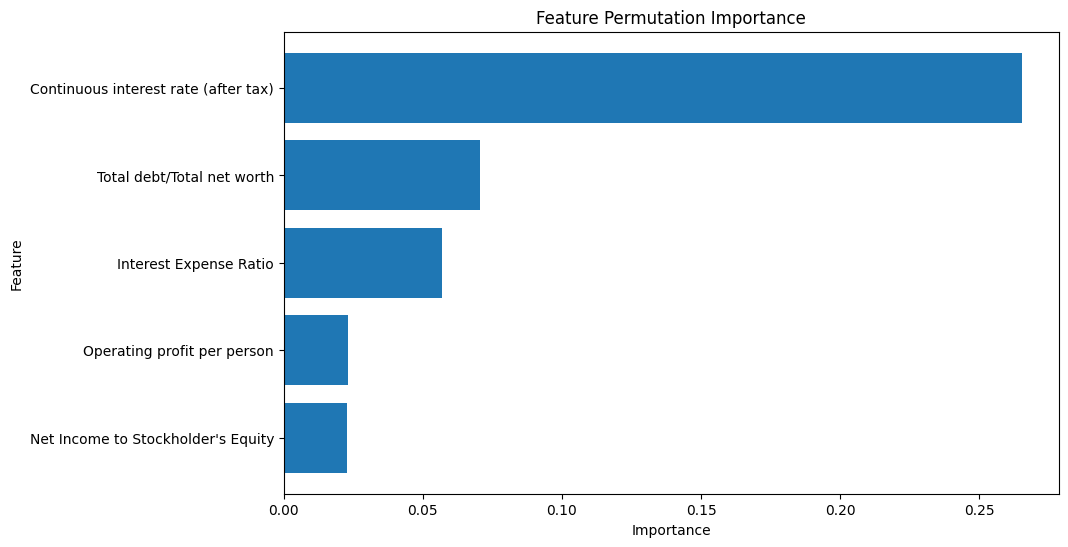

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Original feat removed so far:  ['Continuous interest rate (after tax)']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Interest Expense Ratio']

--- NEW ITERATION ---
Removing feature:  Operating profit per person
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Interest Expense Ratio', 'Operating profit per person']

--- NEW ITERATION ---
Removing feature:  Net Income to Stockholder's Equity
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Interest Expense Ratio', 'Operating profit per person', "Net Income to Stock

In [ ]:
dt2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  1074  246   4      13.99   90.91        81.36     81.67     24.24   
1    6  1239   81  38       6.90   13.64        93.86     91.28      9.16   
2    6  1239   81  38       6.90   13.64        93.86     91.28      9.16   
3    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
4    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
5    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
6    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               86.14                 0   
1               53.75                 1   
2               53.75                 2   
3               50.00                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Tota...  
3   ['Continuous interest rate (after tax)', 'Tota...  
4   ['Continuous interest rate (after tax)', 'Tota...  
5   ['Continuous interest rate (after tax)', 'Tota...  
6   ['Continuous interest rate (after tax)', 'Tota...  
7   ['Continuous interest rate (after tax)', 'Tota...  
8   ['Continuous interest rate (after tax)', 'Tota...  
9   ['Continuous interest rate (after tax)', 'Tota...  
10  ['Continuous interest rate (after tax)', 'Tota...  
11  ['Continuous interest rate (after tax)', 'Tota...  
12  ['Continuous interest rate (after tax)', 'Tota...  
13  ['Continuous interest rate (after tax)', 'Tota...  
14  ['Continuous interest rate (after tax)', 'Tota...  
15  ['Continuous interest rate (after tax)', 'Tota...  
16  ['Continuous interest rate (after tax)', 'Tota...  
17  ['Continuous interest rate (after tax)', 'Tota...  
18  ['Continuous interest rate (after tax)', 'Tota...  
19  ['Continuous interest rate (after tax)', 'Tota...  
20  ['Continuous interest rate (after tax)', 'Tota...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 16:49:00.316972

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Asse

In [ ]:
dt2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  1074  246   4      13.99   90.91        81.36     81.67     24.24   
1   38  1072  248   6      13.29   86.36        81.21     81.38     23.03   
2   38  1059  261   6      12.71   86.36        80.23     80.43     22.16   
3   37  1065  255   7      12.67   84.09        80.68     80.79     22.02   
4   38  1044  276   6      12.10   86.36        79.09     79.33     21.23   
5   37  1062  258   7      12.54   84.09        80.45     80.57     21.83   
6   37  1060  260   7      12.46   84.09        80.30     80.43     21.70   
7   38  1064  256   6      12.93   86.36        80.61     80.79     22.49   
8   36  1064  256   8      12.33   81.82        80.61     80.65     21.43   
9   36  1066  254   8      12.41   81.82        80.76     80.79     21.56   
10  36  1067  253   8      12.46   81.82        80.83     80.87     21.62   
11  36  1065  255   8      12.37   81.82        80.68     80.72     21.49   
12  36  1068  252   8      12.50   81.82        80.91     80.94     21.69   
13  36  1064  256   8      12.33   81.82        80.61     80.65     21.43   
14  35  1068  252   9      12.20   79.55        80.91     80.87     21.15   
15  36  1073  247   8      12.72   81.82        81.29     81.30     22.02   
16  36  1073  247   8      12.72   81.82        81.29     81.30     22.02   
17  36  1078  242   8      12.95   81.82        81.67     81.67     22.36   
18  37  1070  250   7      12.89   84.09        81.06     81.16     22.36   
19  37  1070  250   7      12.89   84.09        81.06     81.16     22.36   
20  37  1102  218   7      14.51   84.09        83.48     83.50     24.75   

    balanced_accuracy  num_feat_missing  \
0               86.14                 0   
1               83.79                 1   
2               83.30                 2   
3               82.39                 3   
4               82.73                 4   
5               82.27                 5   
6               82.20                 6   
7               83.48                 7   
8               81.21                 8   
9               81.29                 9   
10              81.33                10   
11              81.25                11   
12              81.36                12   
13              81.21                13   
14              80.23                14   
15              81.55                15   
16              81.55                16   
17              81.74                17   
18              82.58                18   
19              82.58                19   
20              83.79                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Tota...  
3   ['Continuous interest rate (after tax)', 'Tota...  
4   ['Continuous interest rate (after tax)', 'Tota...  
5   ['Continuous interest rate (after tax)', 'Tota...  
6   ['Continuous interest rate (after tax)', 'Tota...  
7   ['Continuous interest rate (after tax)', 'Tota...  
8   ['Continuous interest rate (after tax)', 'Tota...  
9   ['Continuous interest rate (after tax)', 'Tota...  
10  ['Continuous interest rate (after tax)', 'Tota...  
11  ['Continuous interest rate (after tax)', 'Tota...  
12  ['Continuous interest rate (after tax)', 'Tota...  
13  ['Continuous interest rate (after tax)', 'Tota...  
14  ['Continuous interest rate (after tax)', 'Tota...  
15  ['Continuous interest rate (after tax)', 'Tota...  
16  ['Continuous interest rate (after tax)', 'Tota...  
17  ['Continuous interest rate (after tax)', 'Tota...  
18  ['Continuous interest rate (after tax)', 'Tota...  
19  ['Continuous interest rate (after tax)', 'Tota...  
20  ['Continuous interest rate (after tax)', 'Tota...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  rf2_param_grid = {
    'n_estimators': [300],
    'max_features': [0.5],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.01],
    'max_depth': [5]
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 16:56:58.939265

Nested Cross-validation Results:
Individual scores: [0.85545551 0.86767241 0.84468737]
Average nested CV score: 0.856 (+/- 0.019)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.856
2025-01-16 16:57:57.799314

Execution time: 0.98 minutes




```
Starting hyperparameter tuning at: 2025-01-16 05:49:34.107962

Nested Cross-validation Results:
Individual scores: [0.82368548 0.8856779  0.81324134]
Average nested CV score: 0.841 (+/- 0.064)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.856
2025-01-16 06:56:29.661936

Execution time: 66.93 minutes
```



In [ ]:
# rf2_grid_search.cv_results_

In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
6                Continuous interest rate (after tax)  3.204302e-02  0.002219
1                                Borrowing dependency  2.530180e-02  0.003542
16                             Interest Expense Ratio  1.412845e-02  0.002889
48                Interest-bearing debt interest rate  1.380664e-02  0.003140
0                  Net Income to Stockholder's Equity  1.056706e-02  0.002116
2                   Retained Earnings to Total Assets  1.052875e-02  0.002161
46                         Total debt/Total net worth  8.389265e-03  0.002843
51                         Allocation rate per person  6.837017e-03  0.002190
33                 Degree of Financial Leverage (DFL)  6.060247e-03  0.000997
43                                 Cash Turnover Rate  5.000086e-03  0.001344
18  Interest Coverage Ratio (Interest expense to E...  4.564182e-03  0.000093
13                         Total income/Total expense  4.051861e-03  0.003809
25                          Inventory/Working Capital  3.579470e-03  0.001410
21                             Cash/Current Liability  2.765137e-03  0.000071
15                             Operating Gross Margin  2.670422e-03  0.000071
49                    Inventory Turnover Rate (times)  2.386385e-03  0.001105
47                          Total assets to GNP price  2.291670e-03  0.001298
32                             Cash Flow to Liability  1.723488e-03  0.001333
11                                Equity to Liability  1.571191e-03  0.003048
60                                      Current Ratio  1.534059e-03  0.001369
10                      Equity to Long-term Liability  1.477230e-03  0.001443
29                               Total Asset Turnover  1.401565e-03  0.001377
44                                        Quick Ratio  1.306420e-03  0.002075
8                 Operating Profit Per Share (Yuan ¥)  1.230971e-03  0.001402
53                        Current Asset Turnover Rate  1.174250e-03  0.001181
52                             Operating Expense Rate  1.155307e-03  0.001377
57                        Inventory/Current Liability  1.079535e-03  0.001367
55                       Accounts Receivable Turnover  1.060592e-03  0.001493
37                       Operating Profit Growth Rate  7.576116e-04  0.001238
3                          Current Liabilities/Equity  5.870172e-04  0.001317
38                  Continuous Net Profit Growth Rate  3.787520e-04  0.001141
58                         Revenue Per Share (Yuan ¥)  3.409737e-04  0.000128
50                      Current Liabilities/Liability  3.409737e-04  0.000097
35                             Fixed Assets to Assets  2.273158e-04  0.000046
45                          Quick Asset Turnover Rate  1.894298e-04  0.000158
40                                 Revenue per person  1.326009e-04  0.000114
30                   Contingent liabilities/Net worth  1.326009e-04  0.000097
28                          Quick Assets/Total Assets  1.326009e-04  0.000046
27                                Cash Flow to Equity  9.471491e-05  0.000134
34                            Total Asset Growth Rate  7.577193e-05  0.000126
39               Long-term fund suitability ratio (A)  3.788596e-05  0.000097
26                                 No-credit Interval  1.894298e-05  0.000139
23                                  Cash/Total Assets  2.220446e-17  0.000147
19        Inventory and accounts receivable/Net value -1.894298e-05  0.000071
7                              Working Capital/Equity -3.788596e-05  0.000076
31                    Fixed Assets Turnover Frequency -3.788596e-05  0.000142
56                            Average Collection Days -9.471491e-05  0.000060
59                     Quick Assets/Current Liability -9.471491e-05  0.000147
12                                       Tax rate (A) -1.136579e-04  0.000110
54              Long-term Liability to Current Assets -1.136579e-04  0.000038
22               Total Asset Return Growth Rate Ratio -1.515439e-04 

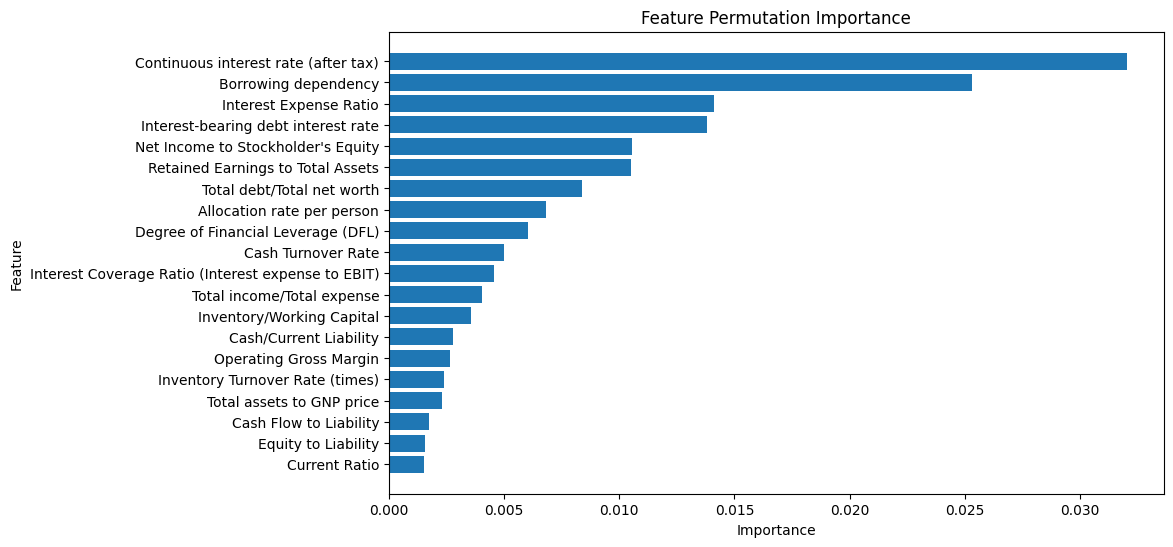

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Original feat removed so far:  ['Continuous interest rate (after tax)']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Borrowing dependency', 'Interest Expense Ratio']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Borrowing dependency', 'Interest Expense Ratio', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Net Income to Stockholder's Equity
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Borrowing dependency', 'Interest Expense Ratio', 'Interest-bearing debt interest rate', "Net Income to Stockholder

In [ ]:
rf2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1204  116   8      23.68   81.82        91.21     90.91     36.73   
1   26  1267   53  18      32.91   59.09        95.98     94.79     42.28   
2   15  1309   11  29      57.69   34.09        99.17     97.07     42.86   
3   15  1309   11  29      57.69   34.09        99.17     97.07     42.86   
4   13  1310   10  31      56.52   29.55        99.24     96.99     38.81   
5   10  1312    8  34      55.56   22.73        99.39     96.92     32.26   
6    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               86.52                 0   
1               77.54                 1   
2               66.63                 2   
3               66.63                 3   
4               64.39                 4   
5               61.06                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Borr...  
3   ['Continuous interest rate (after tax)', 'Borr...  
4   ['Continuous interest rate (after tax)', 'Borr...  
5   ['Continuous interest rate (after tax)', 'Borr...  
6   ['Continuous interest rate (after tax)', 'Borr...  
7   ['Continuous interest rate (after tax)', 'Borr...  
8   ['Continuous interest rate (after tax)', 'Borr...  
9   ['Continuous interest rate (after tax)', 'Borr...  
10  ['Continuous interest rate (after tax)', 'Borr...  
11  ['Continuous interest rate (after tax)', 'Borr...  
12  ['Continuous interest rate (after tax)', 'Borr...  
13  ['Continuous interest rate (after tax)', 'Borr...  
14  ['Continuous interest rate (after tax)', 'Borr...  
15  ['Continuous interest rate (after tax)', 'Borr...  
16  ['Continuous interest rate (after tax)', 'Borr...  
17  ['Continuous interest rate (after tax)', 'Borr...  
18  ['Continuous interest rate (after tax)', 'Borr...  
19  ['Continuous interest rate (after tax)', 'Borr...  
20  ['Continuous interest rate (after tax)', 'Borr...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 16:58:24.697025

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Asse

In [ ]:
rf2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1204  116   8      23.68   81.82        91.21     90.91     36.73   
1   34  1201  119  10      22.22   77.27        90.98     90.54     34.52   
2   34  1204  116  10      22.67   77.27        91.21     90.76     35.05   
3   34  1203  117  10      22.52   77.27        91.14     90.69     34.87   
4   34  1200  120  10      22.08   77.27        90.91     90.47     34.34   
5   34  1204  116  10      22.67   77.27        91.21     90.76     35.05   
6   34  1210  110  10      23.61   77.27        91.67     91.20     36.17   
7   34  1217  103  10      24.82   77.27        92.20     91.72     37.57   
8   34  1217  103  10      24.82   77.27        92.20     91.72     37.57   
9   34  1223   97  10      25.95   77.27        92.65     92.16     38.86   
10  34  1218  102  10      25.00   77.27        92.27     91.79     37.78   
11  34  1224   96  10      26.15   77.27        92.73     92.23     39.08   
12  28  1245   75  16      27.18   63.64        94.32     93.33     38.10   
13  28  1246   74  16      27.45   63.64        94.39     93.40     38.36   
14  28  1246   74  16      27.45   63.64        94.39     93.40     38.36   
15  29  1246   74  15      28.16   65.91        94.39     93.48     39.46   
16  29  1247   73  15      28.43   65.91        94.47     93.55     39.73   
17  29  1247   73  15      28.43   65.91        94.47     93.55     39.73   
18  29  1248   72  15      28.71   65.91        94.55     93.62     40.00   
19  23  1269   51  21      31.08   52.27        96.14     94.72     38.98   
20  21  1272   48  23      30.43   47.73        96.36     94.79     37.17   

    balanced_accuracy  num_feat_missing  \
0               86.52                 0   
1               84.13                 1   
2               84.24                 2   
3               84.20                 3   
4               84.09                 4   
5               84.24                 5   
6               84.47                 6   
7               84.73                 7   
8               84.73                 8   
9               84.96                 9   
10              84.77                10   
11              85.00                11   
12              78.98                12   
13              79.02                13   
14              79.02                14   
15              80.15                15   
16              80.19                16   
17              80.19                17   
18              80.23                18   
19              74.20                19   
20              72.05                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Borr...  
3   ['Continuous interest rate (after tax)', 'Borr...  
4   ['Continuous interest rate (after tax)', 'Borr...  
5   ['Continuous interest rate (after tax)', 'Borr...  
6   ['Continuous interest rate (after tax)', 'Borr...  
7   ['Continuous interest rate (after tax)', 'Borr...  
8   ['Continuous interest rate (after tax)', 'Borr...  
9   ['Continuous interest rate (after tax)', 'Borr...  
10  ['Continuous interest rate (after tax)', 'Borr...  
11  ['Continuous interest rate (after tax)', 'Borr...  
12  ['Continuous interest rate (after tax)', 'Borr...  
13  ['Continuous interest rate (after tax)', 'Borr...  
14  ['Continuous interest rate (after tax)', 'Borr...  
15  ['Continuous interest rate (after tax)', 'Borr...  
16  ['Continuous interest rate (after tax)', 'Borr...  
17  ['Continuous interest rate (after tax)', 'Borr...  
18  ['Continuous interest rate (after tax)', 'Borr...  
19  ['Continuous interest rate (after tax)', 'Borr...  
20  ['Continuous interest rate (after tax)', 'Borr...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [25, 15, 1],
      'min_split_gain': [1.0, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'min_child_samples': [15],
      'min_split_gain': [1.0],
      'reg_lambda': [10.0]
  }

gbt2_classifier = LGBMClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 17:06:24.576860

Nested Cross-validation Results:
Individual scores: [0.84385593 0.89789381 0.81443135]
Average nested CV score: 0.852 (+/- 0.069)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 15, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.852
2025-01-16 17:06:31.204561

Execution time: 0.11 minutes




```
Starting hyperparameter tuning at: 2025-01-13 02:38:19.428751

Nested Cross-validation Results:
Individual scores: [0.87462924 0.81263715 0.82063191]
Average nested CV score: 0.836 (+/- 0.055)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 25, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.843
2025-01-13 02:45:44.987140

Execution time: 7.43 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 19:43:03.120577

Nested Cross-validation Results:
Individual scores: [0.83509727 0.87402038 0.83166476]
Average nested CV score: 0.847 (+/- 0.038)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 15, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.852
2025-01-15 19:50:40.259765

Execution time: 7.62 minutes
```



In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
6                Continuous interest rate (after tax)    0.131436  0.011517
46                         Total debt/Total net worth    0.052573  0.008924
44                                        Quick Ratio    0.028029  0.006010
1                                Borrowing dependency    0.017309  0.003213
48                Interest-bearing debt interest rate    0.010492  0.005642
16                             Interest Expense Ratio    0.010056  0.002312
55                       Accounts Receivable Turnover    0.009488  0.002260
9                         Operating profit per person    0.008902  0.002604
5                             Net Value Per Share (A)    0.008617  0.001095
17                                      CFO to Assets    0.007481  0.002384
2                   Retained Earnings to Total Assets    0.007328  0.003324
43                                 Cash Turnover Rate    0.006989  0.002030
24                   After-tax Net Profit Growth Rate    0.006667  0.001595
20                               Total expense/Assets    0.006250  0.002778
53                        Current Asset Turnover Rate    0.005928  0.003814
36                              Net Value Growth Rate    0.005719  0.001081
56                            Average Collection Days    0.005606  0.000895
35                             Fixed Assets to Assets    0.005568  0.000341
21                             Cash/Current Liability    0.004697  0.002146
38                  Continuous Net Profit Growth Rate    0.004678  0.004157
37                       Operating Profit Growth Rate    0.004470  0.001578
11                                Equity to Liability    0.003182  0.001502
41            Realized Sales Gross Profit Growth Rate    0.002974  0.001158
31                    Fixed Assets Turnover Frequency    0.002841  0.000085
49                    Inventory Turnover Rate (times)    0.002595  0.001894
27                                Cash Flow to Equity    0.002500  0.000372
13                         Total income/Total expense    0.002405  0.001437
47                          Total assets to GNP price    0.002102  0.001107
42              Research and development expense rate    0.002027  0.001442
34                            Total Asset Growth Rate    0.001988  0.002236
3                          Current Liabilities/Equity    0.001666  0.001227
0                  Net Income to Stockholder's Equity    0.001363  0.000272
25                          Inventory/Working Capital    0.001117  0.001449
40                                 Revenue per person    0.001042  0.000393
51                         Allocation rate per person    0.000890  0.001139
58                         Revenue Per Share (Yuan ¥)    0.000852  0.001241
33                 Degree of Financial Leverage (DFL)    0.000625  0.000114
4                 Current Liability to Current Assets    0.000568  0.001392
50                      Current Liabilities/Liability    0.000455  0.001014
57                        Inventory/Current Liability    0.000398  0.001333
28                          Quick Assets/Total Assets    0.000379  0.000254
45                          Quick Asset Turnover Rate    0.000208  0.001176
18  Interest Coverage Ratio (Interest expense to E...    0.000076  0.000038
52                             Operating Expense Rate    0.000057  0.000097
7                              Working Capital/Equity    0.000038  0.000046
22               Total Asset Return Growth Rate Ratio    0.000019  0.000038
10                      Equity to Long-term Liability   -0.000133  0.000142
59                     Quick Assets/Current Liability   -0.000133  0.000076
23                                  Cash/Total Assets   -0.000701  0.000195

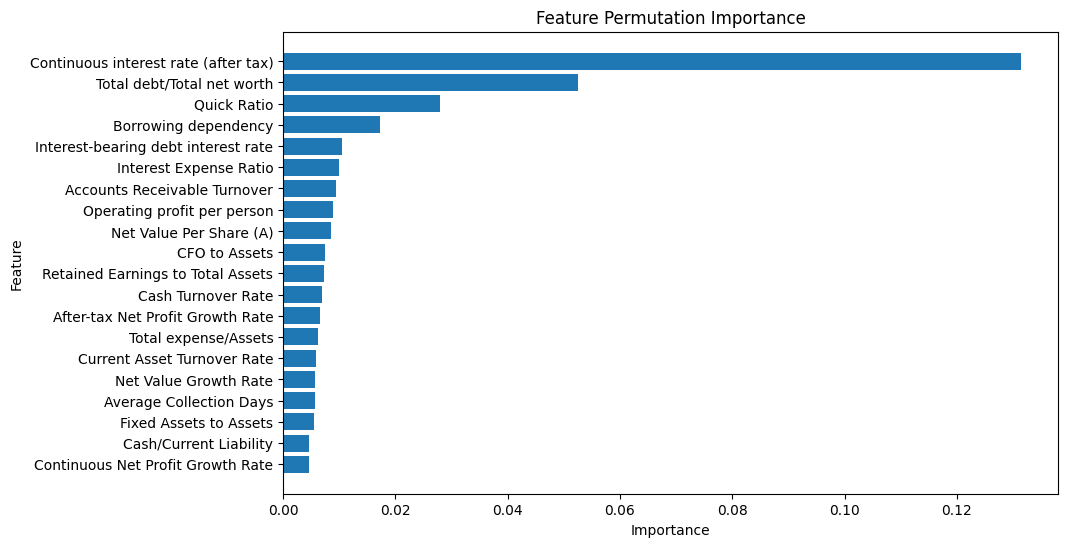

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Original feat removed so far:  ['Continuous interest rate (after tax)']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Quick Ratio', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Quick Ratio', 'Borrowing dependency', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Int

In [ ]:
gbt2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1185  135   8      21.05   81.82        89.77     89.52     33.49   
1   21  1266   54  23      28.00   47.73        95.91     94.35     35.29   
2   15  1285   35  29      30.00   34.09        97.35     95.31     31.91   
3    2  1316    4  42      33.33    4.55        99.70     96.63      8.00   
4    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
5    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
6    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               85.80                 0   
1               71.82                 1   
2               65.72                 2   
3               52.12                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Tota...  
3   ['Continuous interest rate (after tax)', 'Tota...  
4   ['Continuous interest rate (after tax)', 'Tota...  
5   ['Continuous interest rate (after tax)', 'Tota...  
6   ['Continuous interest rate (after tax)', 'Tota...  
7   ['Continuous interest rate (after tax)', 'Tota...  
8   ['Continuous interest rate (after tax)', 'Tota...  
9   ['Continuous interest rate (after tax)', 'Tota...  
10  ['Continuous interest rate (after tax)', 'Tota...  
11  ['Continuous interest rate (after tax)', 'Tota...  
12  ['Continuous interest rate (after tax)', 'Tota...  
13  ['Continuous interest rate (after tax)', 'Tota...  
14  ['Continuous interest rate (after tax)', 'Tota...  
15  ['Continuous interest rate (after tax)', 'Tota...  
16  ['Continuous interest rate (after tax)', 'Tota...  
17  ['Continuous interest rate (after tax)', 'Tota...  
18  ['Continuous interest rate (after tax)', 'Tota...  
19  ['Continuous interest rate (after tax)', 'Tota...  
20  ['Continuous interest rate (after tax)', 'Tota...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 17:06:34.920398

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Asse

In [ ]:
gbt2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1185  135   8      21.05   81.82        89.77     89.52     33.49   
1   35  1184  136   9      20.47   79.55        89.70     89.37     32.56   
2   35  1178  142   9      19.77   79.55        89.24     88.93     31.67   
3   29  1238   82  15      26.13   65.91        93.79     92.89     37.42   
4   29  1245   75  15      27.88   65.91        94.32     93.40     39.19   
5   27  1205  115  17      19.01   61.36        91.29     90.32     29.03   
6   27  1205  115  17      19.01   61.36        91.29     90.32     29.03   
7   26  1216  104  18      20.00   59.09        92.12     91.06     29.89   
8   28  1216  104  16      21.21   63.64        92.12     91.20     31.82   
9   28  1223   97  16      22.40   63.64        92.65     91.72     33.14   
10  28  1222   98  16      22.22   63.64        92.58     91.64     32.94   
11  27  1227   93  17      22.50   61.36        92.95     91.94     32.93   
12  26  1236   84  18      23.64   59.09        93.64     92.52     33.77   
13  25  1235   85  19      22.73   56.82        93.56     92.38     32.47   
14  25  1240   80  19      23.81   56.82        93.94     92.74     33.56   
15  25  1235   85  19      22.73   56.82        93.56     92.38     32.47   
16  23  1257   63  21      26.74   52.27        95.23     93.84     35.38   
17  23  1246   74  21      23.71   52.27        94.39     93.04     32.62   
18  25  1238   82  19      23.36   56.82        93.79     92.60     33.11   
19  26  1215  105  18      19.85   59.09        92.05     90.98     29.71   
20  26  1214  106  18      19.70   59.09        91.97     90.91     29.55   

    balanced_accuracy  num_feat_missing  \
0               85.80                 0   
1               84.62                 1   
2               84.39                 2   
3               79.85                 3   
4               80.11                 4   
5               76.33                 5   
6               76.33                 6   
7               75.61                 7   
8               77.88                 8   
9               78.14                 9   
10              78.11                10   
11              77.16                11   
12              76.36                12   
13              75.19                13   
14              75.38                14   
15              75.19                15   
16              73.75                16   
17              73.33                17   
18              75.30                18   
19              75.57                19   
20              75.53                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Tota...  
3   ['Continuous interest rate (after tax)', 'Tota...  
4   ['Continuous interest rate (after tax)', 'Tota...  
5   ['Continuous interest rate (after tax)', 'Tota...  
6   ['Continuous interest rate (after tax)', 'Tota...  
7   ['Continuous interest rate (after tax)', 'Tota...  
8   ['Continuous interest rate (after tax)', 'Tota...  
9   ['Continuous interest rate (after tax)', 'Tota...  
10  ['Continuous interest rate (after tax)', 'Tota...  
11  ['Continuous interest rate (after tax)', 'Tota...  
12  ['Continuous interest rate (after tax)', 'Tota...  
13  ['Continuous interest rate (after tax)', 'Tota...  
14  ['Continuous interest rate (after tax)', 'Tota...  
15  ['Continuous interest rate (after tax)', 'Tota...  
16  ['Continuous interest rate (after tax)', 'Tota...  
17  ['Continuous interest rate (after tax)', 'Tota...  
18  ['Continuous interest rate (after tax)', 'Tota...  
19  ['Continuous interest rate (after tax)', 'Tota...  
20  ['Continuous interest rate (after tax)', 'Tota...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # best model
  xgb2_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[10.0],
    'gamma': [1.0],
    'colsample_bytree':[0.25]
}

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 17:14:34.624590

Nested Cross-validation Results:
Individual scores: [0.81261075 0.84711011 0.78632409]
Average nested CV score: 0.815 (+/- 0.050)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.815
2025-01-16 17:14:40.654751

Execution time: 0.10 minutes




```
Starting hyperparameter tuning at: 2025-01-13 02:09:56.887533

Nested Cross-validation Results:
Individual scores: [0.59037943 0.6359424  0.65874293]
Average nested CV score: 0.628 (+/- 0.057)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0}

Best Model Performance:
Best CV score: 0.667
2025-01-13 02:30:42.096814

Execution time: 20.75 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 19:50:40.268354

Nested Cross-validation Results:
Individual scores: [0.82165351 0.84711011 0.78632409]
Average nested CV score: 0.818 (+/- 0.050)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.815
2025-01-15 20:11:51.367537

Execution time: 21.18 minutes
```


In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
48                Interest-bearing debt interest rate    0.012594  0.003971
9                         Operating profit per person    0.008050  0.001157
44                                        Quick Ratio    0.006912  0.003490
21                             Cash/Current Liability    0.004167  0.001508
43                                 Cash Turnover Rate    0.003788  0.000240
6                Continuous interest rate (after tax)    0.002290  0.003566
40                                 Revenue per person    0.002140  0.001125
37                       Operating Profit Growth Rate    0.001762  0.001142
24                   After-tax Net Profit Growth Rate    0.000966  0.000235
42              Research and development expense rate    0.000890  0.000554
49                    Inventory Turnover Rate (times)    0.000815  0.000367
50                      Current Liabilities/Liability    0.000758  0.000472
13                         Total income/Total expense    0.000663  0.000224
53                        Current Asset Turnover Rate    0.000625  0.000229
30                   Contingent liabilities/Net worth    0.000587  0.000235
25                          Inventory/Working Capital    0.000530  0.000221
55                       Accounts Receivable Turnover    0.000530  0.001243
31                    Fixed Assets Turnover Frequency    0.000474  0.000232
7                              Working Capital/Equity    0.000417  0.000258
10                      Equity to Long-term Liability    0.000303  0.000193
45                          Quick Asset Turnover Rate    0.000208  0.000110
20                               Total expense/Assets    0.000208  0.001606
52                             Operating Expense Rate    0.000189  0.000189
58                         Revenue Per Share (Yuan ¥)    0.000189  0.000208
39               Long-term fund suitability ratio (A)    0.000170  0.000163
54              Long-term Liability to Current Assets    0.000133  0.000244
57                        Inventory/Current Liability    0.000133  0.000046
26                                 No-credit Interval    0.000114  0.000250
22               Total Asset Return Growth Rate Ratio    0.000095  0.000180
60                                      Current Ratio    0.000057  0.000046
56                            Average Collection Days    0.000019  0.000093
23                                  Cash/Total Assets   -0.000019  0.000110
33                 Degree of Financial Leverage (DFL)   -0.000038  0.000076
35                             Fixed Assets to Assets   -0.000038  0.001402
5                             Net Value Per Share (A)   -0.000038  0.001188
27                                Cash Flow to Equity   -0.000076  0.000560
41            Realized Sales Gross Profit Growth Rate   -0.000095  0.000104
28                          Quick Assets/Total Assets   -0.000114  0.000351
29                               Total Asset Turnover   -0.000133  0.000097
19        Inventory and accounts receivable/Net value   -0.000133  0.000128
12                                       Tax rate (A)   -0.000189  0.000120
18  Interest Coverage Ratio (Interest expense to E...   -0.000208  0.000110
15                             Operating Gross Margin   -0.000227  0.000278
51                         Allocation rate per person   -0.000436  0.000204
32                             Cash Flow to Liability   -0.000530  0.000303
47                          Total assets to GNP price   -0.000758  0.000317
34                            Total Asset Growth Rate   -0.000852  0.000287
3                          Current Liabilities/Equity   -0.000966  0.000421
38                  Continuous Net Profit Growth Rate   -0.001194  0.001134
59                     Quick Assets/Current Liability   -0.001421  0.000147
16                             Interest Expense Ratio   -0.001496  0.000152
46                         Total debt/Total net worth   -0.001837  0.000154
17                

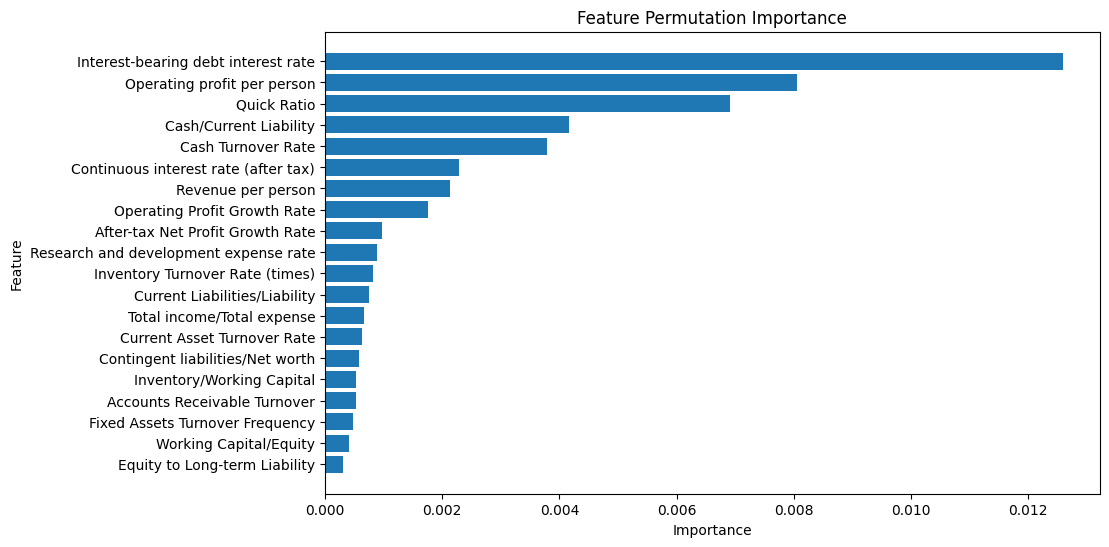

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Operating profit per person
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Operating profit per person']

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Operating profit per person', 'Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Operating profit per person', 'Quick Ratio', 'Cash/Current Liability']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Operating profit per person', 'Quick Ratio', 'Cash/Current Liability', 'Cash Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after 

In [ ]:
xgb2_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   30  1233  87  14      25.64   68.18        93.41     92.60     37.27   
1   21  1262  58  23      26.58   47.73        95.61     94.06     34.15   
2   23  1264  56  21      29.11   52.27        95.76     94.35     37.40   
3   17  1283  37  27      31.48   38.64        97.20     95.31     34.69   
4   22  1260  60  22      26.83   50.00        95.45     93.99     34.92   
5   25  1252  68  19      26.88   56.82        94.85     93.62     36.50   
6   17  1282  38  27      30.91   38.64        97.12     95.23     34.34   
7   17  1282  38  27      30.91   38.64        97.12     95.23     34.34   
8   18  1275  45  26      28.57   40.91        96.59     94.79     33.64   
9   20  1270  50  24      28.57   45.45        96.21     94.57     35.09   
10  21  1271  49  23      30.00   47.73        96.29     94.72     36.84   
11  22  1269  51  22      30.14   50.00        96.14     94.65     37.61   
12  22  1266  54  22      28.95   50.00        95.91     94.43     36.67   
13  22  1271  49  22      30.99   50.00        96.29     94.79     38.26   
14  23  1273  47  21      32.86   52.27        96.44     95.01     40.35   
15  23  1274  46  21      33.33   52.27        96.52     95.09     40.71   
16  23  1270  50  21      31.51   52.27        96.21     94.79     39.32   
17  21  1278  42  23      33.33   47.73        96.82     95.23     39.25   
18  21  1277  43  23      32.81   47.73        96.74     95.16     38.89   
19  21  1278  42  23      33.33   47.73        96.82     95.23     39.25   
20  20  1276  44  24      31.25   45.45        96.67     95.01     37.04   

    balanced_accuracy  num_feat_missing  \
0               80.80                 0   
1               71.67                 1   
2               74.02                 2   
3               67.92                 3   
4               72.73                 4   
5               75.83                 5   
6               67.88                 6   
7               67.88                 7   
8               68.75                 8   
9               70.83                 9   
10              72.01                10   
11              73.07                11   
12              72.95                12   
13              73.14                13   
14              74.36                14   
15              74.39                15   
16              74.24                16   
17              72.27                17   
18              72.23                18   
19              72.27                19   
20              71.06                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Opera...  
3   ['Interest-bearing debt interest rate', 'Opera...  
4   ['Interest-bearing debt interest rate', 'Opera...  
5   ['Interest-bearing debt interest rate', 'Opera...  
6   ['Interest-bearing debt interest rate', 'Opera...  
7   ['Interest-bearing debt interest rate', 'Opera...  
8   ['Interest-bearing debt interest rate', 'Opera...  
9   ['Interest-bearing debt interest rate', 'Opera...  
10  ['Interest-bearing debt interest rate', 'Opera...  
11  ['Interest-bearing debt interest rate', 'Opera...  
12  ['Interest-bearing debt interest rate', 'Opera...  
13  ['Interest-bearing debt interest rate', 'Opera...  
14  ['Interest-bearing debt interest rate', 'Opera...  
15  ['Interest-bearing debt interest rate', 'Opera...  
16  ['Interest-bearing debt interest rate', 'Opera...  
17  ['Interest-bearing debt interest rate', 'Opera...  
18  ['Interest-bearing debt interest rate', 'Opera...  
19  ['Interest-bearing debt interest rate', 'Opera...  
20  ['Interest-bearing debt interest rate', 'Opera...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 17:14:44.460221

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Asset

In [ ]:
xgb2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   30  1233   87  14      25.64   68.18        93.41     92.60     37.27   
1   32  1219  101  12      24.06   72.73        92.35     91.72     36.16   
2   32  1217  103  12      23.70   72.73        92.20     91.57     35.75   
3   27  1259   61  17      30.68   61.36        95.38     94.28     40.91   
4   32  1225   95  12      25.20   72.73        92.80     92.16     37.43   
5   30  1225   95  14      24.00   68.18        92.80     92.01     35.50   
6   30  1224   96  14      23.81   68.18        92.73     91.94     35.29   
7   30  1228   92  14      24.59   68.18        93.03     92.23     36.14   
8   28  1234   86  16      24.56   63.64        93.48     92.52     35.44   
9   30  1234   86  14      25.86   68.18        93.48     92.67     37.50   
10  29  1231   89  15      24.58   65.91        93.26     92.38     35.80   
11  29  1236   84  15      25.66   65.91        93.64     92.74     36.94   
12  28  1236   84  16      25.00   63.64        93.64     92.67     35.90   
13  29  1244   76  15      27.62   65.91        94.24     93.33     38.93   
14  30  1234   86  14      25.86   68.18        93.48     92.67     37.50   
15  30  1238   82  14      26.79   68.18        93.79     92.96     38.46   
16  30  1241   79  14      27.52   68.18        94.02     93.18     39.22   
17  29  1245   75  15      27.88   65.91        94.32     93.40     39.19   
18  28  1243   77  16      26.67   63.64        94.17     93.18     37.58   
19  28  1245   75  16      27.18   63.64        94.32     93.33     38.10   
20  28  1236   84  16      25.00   63.64        93.64     92.67     35.90   

    balanced_accuracy  num_feat_missing  \
0               80.80                 0   
1               82.54                 1   
2               82.46                 2   
3               78.37                 3   
4               82.77                 4   
5               80.49                 5   
6               80.45                 6   
7               80.61                 7   
8               78.56                 8   
9               80.83                 9   
10              79.58                10   
11              79.77                11   
12              78.64                12   
13              80.08                13   
14              80.83                14   
15              80.98                15   
16              81.10                16   
17              80.11                17   
18              78.90                18   
19              78.98                19   
20              78.64                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Opera...  
3   ['Interest-bearing debt interest rate', 'Opera...  
4   ['Interest-bearing debt interest rate', 'Opera...  
5   ['Interest-bearing debt interest rate', 'Opera...  
6   ['Interest-bearing debt interest rate', 'Opera...  
7   ['Interest-bearing debt interest rate', 'Opera...  
8   ['Interest-bearing debt interest rate', 'Opera...  
9   ['Interest-bearing debt interest rate', 'Opera...  
10  ['Interest-bearing debt interest rate', 'Opera...  
11  ['Interest-bearing debt interest rate', 'Opera...  
12  ['Interest-bearing debt interest rate', 'Opera...  
13  ['Interest-bearing debt interest rate', 'Opera...  
14  ['Interest-bearing debt interest rate', 'Opera...  
15  ['Interest-bearing debt interest rate', 'Opera...  
16  ['Interest-bearing debt interest rate', 'Opera...  
17  ['Interest-bearing debt interest rate', 'Opera...  
18  ['Interest-bearing debt interest rate', 'Opera...  
19  ['Interest-bearing debt interest rate', 'Opera...  
20  ['Interest-bearing debt interest rate', 'Opera...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et2_param_grid = {
      'n_estimators': [500],
      'max_depth': [5],
      'max_features':[1.0],
      'min_samples_split': [0.005],
      'min_samples_leaf': [0.005]
  }

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 17:22:47.435722

Nested Cross-validation Results:
Individual scores: [0.83774557 0.91163793 0.84964493]
Average nested CV score: 0.866 (+/- 0.065)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 500}

Best Model Performance:
Best CV score: 0.866
2025-01-16 17:23:07.131885

Execution time: 0.33 minutes




```
Starting hyperparameter tuning at: 2025-01-15 20:11:51.377031

Nested Cross-validation Results:
Individual scores: [0.8118933  0.89183973 0.84646515]
Average nested CV score: 0.850 (+/- 0.065)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 500}

Best Model Performance:
Best CV score: 0.866
2025-01-15 20:34:22.499819

Execution time: 22.52 minutes
```



In [ ]:
# et2_grid_search.cv_results_

In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
12                                       Tax rate (A)    0.040488  0.009727
18  Interest Coverage Ratio (Interest expense to E...    0.010719  0.002129
1                                Borrowing dependency    0.010510  0.004691
34                            Total Asset Growth Rate    0.006590  0.002895
16                             Interest Expense Ratio    0.006534  0.001354
43                                 Cash Turnover Rate    0.006231  0.002546
11                                Equity to Liability    0.005908  0.003766
10                      Equity to Long-term Liability    0.004507  0.001222
17                                      CFO to Assets    0.003939  0.002792
29                               Total Asset Turnover    0.002879  0.001830
33                 Degree of Financial Leverage (DFL)    0.002500  0.000046
31                    Fixed Assets Turnover Frequency    0.002311  0.000996
3                          Current Liabilities/Equity    0.002310  0.000954
35                             Fixed Assets to Assets    0.002197  0.002160
23                                  Cash/Total Assets    0.001950  0.002459
49                    Inventory Turnover Rate (times)    0.001875  0.001495
46                         Total debt/Total net worth    0.001363  0.001047
0                  Net Income to Stockholder's Equity    0.000416  0.002334
45                          Quick Asset Turnover Rate    0.000398  0.000071
19        Inventory and accounts receivable/Net value    0.000360  0.000163
28                          Quick Assets/Total Assets    0.000360  0.000193
58                         Revenue Per Share (Yuan ¥)    0.000246  0.000165
22               Total Asset Return Growth Rate Ratio    0.000189  0.000134
24                   After-tax Net Profit Growth Rate    0.000133  0.000097
25                          Inventory/Working Capital    0.000133  0.000046
30                   Contingent liabilities/Net worth    0.000133  0.000097
42              Research and development expense rate    0.000057  0.000097
36                              Net Value Growth Rate    0.000057  0.000229
26                                 No-credit Interval    0.000057  0.000046
56                            Average Collection Days    0.000057  0.000046
21                             Cash/Current Liability    0.000057  0.000076
54              Long-term Liability to Current Assets    0.000038  0.000046
53                        Current Asset Turnover Rate    0.000038  0.000046
40                                 Revenue per person    0.000019  0.000071
37                       Operating Profit Growth Rate    0.000019  0.000110
47                          Total assets to GNP price    0.000019  0.000038
50                      Current Liabilities/Liability   -0.000038  0.000076
6                Continuous interest rate (after tax)   -0.000057  0.000142
52                             Operating Expense Rate   -0.000057  0.000097
7                              Working Capital/Equity   -0.000076  0.000152
27                                Cash Flow to Equity   -0.000076  0.000038
44                                        Quick Ratio   -0.000095  0.000189
48                Interest-bearing debt interest rate   -0.000227  0.000097
51                         Allocation rate per person   -0.000246  0.000076
15                             Operating Gross Margin   -0.000322  0.000244
20                               Total expense/Assets   -0.000322  0.000076
32                             Cash Flow to Liability   -0.000360  0.000152
59                     Quick Assets/Current Liability   -0.000379  0.000247
2                   Retained Earnings to Total Assets   -0.000646  0.004034
8                 Operating Profit Per Share (Yuan ¥)   -0.000777  0.001543
4                 Current Liability to Current Assets   -0.001213  0.001500
60                                      Current Ratio   -0.001231  0.000305
9                 

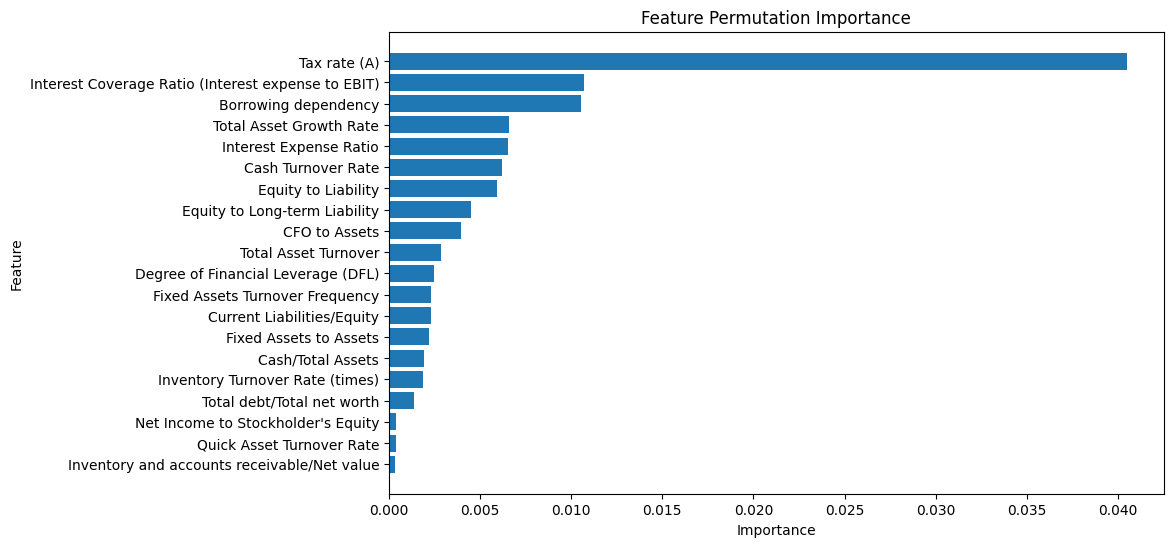

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Tax rate (A)
Original feat removed so far:  ['Tax rate (A)']

--- NEW ITERATION ---
Removing feature:  Interest Coverage Ratio (Interest expense to EBIT)
Original feat removed so far:  ['Tax rate (A)', 'Interest Coverage Ratio (Interest expense to EBIT)']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Tax rate (A)', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Total Asset Growth Rate
Original feat removed so far:  ['Tax rate (A)', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Borrowing dependency', 'Total Asset Growth Rate']

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Tax rate (A)', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Borrowing dependency', 'Total Asset Growth Rate', 'Interest Expense Ratio']

--- NEW ITERATION ---
Removing feature:  Cash Tur

In [ ]:
et2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  1131  189   4      17.47   90.91        85.68     85.85     29.30   
1   31  1213  107  13      22.46   70.45        91.89     91.20     34.07   
2   31  1232   88  13      26.05   70.45        93.33     92.60     38.04   
3   24  1271   49  20      32.88   54.55        96.29     94.94     41.03   
4   24  1278   42  20      36.36   54.55        96.82     95.45     43.64   
5   24  1280   40  20      37.50   54.55        96.97     95.60     44.44   
6   24  1280   40  20      37.50   54.55        96.97     95.60     44.44   
7   20  1297   23  24      46.51   45.45        98.26     96.55     45.98   
8   20  1298   22  24      47.62   45.45        98.33     96.63     46.51   
9   18  1299   21  26      46.15   40.91        98.41     96.55     43.37   
10  18  1299   21  26      46.15   40.91        98.41     96.55     43.37   
11  18  1299   21  26      46.15   40.91        98.41     96.55     43.37   
12  15  1303   17  29      46.88   34.09        98.71     96.63     39.47   
13  12  1308   12  32      50.00   27.27        99.09     96.77     35.29   
14  11  1308   12  33      47.83   25.00        99.09     96.70     32.84   
15   9  1309   11  35      45.00   20.45        99.17     96.63     28.12   
16   9  1309   11  35      45.00   20.45        99.17     96.63     28.12   
17   8  1309   11  36      42.11   18.18        99.17     96.55     25.40   
18   4  1315    5  40      44.44    9.09        99.62     96.70     15.09   
19   4  1315    5  40      44.44    9.09        99.62     96.70     15.09   
20   4  1318    2  40      66.67    9.09        99.85     96.92     16.00   

    balanced_accuracy  num_feat_missing  \
0               88.30                 0   
1               81.17                 1   
2               81.89                 2   
3               75.42                 3   
4               75.68                 4   
5               75.76                 5   
6               75.76                 6   
7               71.86                 7   
8               71.89                 8   
9               69.66                 9   
10              69.66                10   
11              69.66                11   
12              66.40                12   
13              63.18                13   
14              62.05                14   
15              59.81                15   
16              59.81                16   
17              58.67                17   
18              54.36                18   
19              54.36                19   
20              54.47                20   

                                              imputed  
0                                                      
1                            ['Tax rate (A)'] imputed  
2   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
3   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
4   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
5   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
6   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
7   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
8   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
9   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
10  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
11  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
12  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
13  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
14  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
15  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
16  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
17  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
18  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
19  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
20  ['Tax rate (A)', 'Interest Coverage Ratio (Int...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 17:23:25.390558

--- NEW ITERATION ---
Removing feature:  Tax rate (A)
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Assets', 'Total Asset Turnov

In [ ]:
et2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  1131  189   4      17.47   90.91        85.68     85.85     29.30   
1   34  1187  133  10      20.36   77.27        89.92     89.52     32.23   
2   34  1194  126  10      21.25   77.27        90.45     90.03     33.33   
3   32  1194  126  12      20.25   72.73        90.45     89.88     31.68   
4   34  1185  135  10      20.12   77.27        89.77     89.37     31.92   
5   32  1188  132  12      19.51   72.73        90.00     89.44     30.77   
6   33  1191  129  11      20.37   75.00        90.23     89.74     32.04   
7   33  1194  126  11      20.75   75.00        90.45     89.96     32.51   
8   32  1202  118  12      21.33   72.73        91.06     90.47     32.99   
9   31  1204  116  13      21.09   70.45        91.21     90.54     32.46   
10  32  1206  114  12      21.92   72.73        91.36     90.76     33.68   
11  30  1206  114  14      20.83   68.18        91.36     90.62     31.91   
12  30  1215  105  14      22.22   68.18        92.05     91.28     33.52   
13  30  1220  100  14      23.08   68.18        92.42     91.64     34.48   
14  30  1220  100  14      23.08   68.18        92.42     91.64     34.48   
15  30  1222   98  14      23.44   68.18        92.58     91.79     34.88   
16  30  1221   99  14      23.26   68.18        92.50     91.72     34.68   
17  27  1232   88  17      23.48   61.36        93.33     92.30     33.96   
18  26  1238   82  18      24.07   59.09        93.79     92.67     34.21   
19  26  1237   83  18      23.85   59.09        93.71     92.60     33.99   
20  25  1242   78  19      24.27   56.82        94.09     92.89     34.01   

    balanced_accuracy  num_feat_missing  \
0               88.30                 0   
1               83.60                 1   
2               83.86                 2   
3               81.59                 3   
4               83.52                 4   
5               81.36                 5   
6               82.61                 6   
7               82.73                 7   
8               81.89                 8   
9               80.83                 9   
10              82.05                10   
11              79.77                11   
12              80.11                12   
13              80.30                13   
14              80.30                14   
15              80.38                15   
16              80.34                16   
17              77.35                17   
18              76.44                18   
19              76.40                19   
20              75.45                20   

                                              imputed  
0                                                      
1                            ['Tax rate (A)'] imputed  
2   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
3   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
4   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
5   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
6   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
7   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
8   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
9   ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
10  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
11  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
12  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
13  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
14  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
15  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
16  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
17  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
18  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
19  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  
20  ['Tax rate (A)', 'Interest Coverage Ratio (Int...

##**Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm2_param_grid = {
    'C': [20],
    'kernel': ['linear'],
    'gamma': ['scale'],
    'degree': [2]
}

svm2_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 3, 3, 'balanced_accuracy', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-16 17:31:29.733726

Nested Cross-validation Results:
Individual scores: [0.83575693 0.83708856 0.80920881]
Average nested CV score: 0.827 (+/- 0.026)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 20, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.827
2025-01-16 17:31:38.135504

Execution time: 0.14 minutes


```
Starting hyperparameter tuning at: 2025-01-15 20:34:22.511400

Nested Cross-validation Results:
Individual scores: [0.83291602 0.83623629 0.80778755]
Average nested CV score: 0.826 (+/- 0.025)

Fitting final model on entire dataset...
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best parameters: {'C': 20, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.827
2025-01-15 20:40:22.745778

Execution time: 6.00 minutes
```



In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(svm2_classifier, X_train_scaled, y_train, scoring_metric="balanced_accuracy")
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11                                Equity to Liability    0.051741  0.009271
29                               Total Asset Turnover    0.038467  0.007429
23                                  Cash/Total Assets    0.035888  0.006221
1                                Borrowing dependency    0.016116  0.005661
20                               Total expense/Assets    0.016043  0.004622
32                             Cash Flow to Liability    0.014773  0.005031
2                   Retained Earnings to Total Assets    0.013767  0.003015
14                              Liability-Assets Flag    0.011932  0.000060
10                      Equity to Long-term Liability    0.010757  0.001574
50                      Current Liabilities/Liability    0.008391  0.005695
28                          Quick Assets/Total Assets    0.004490  0.003399
52                             Operating Expense Rate    0.004204  0.002874
46                         Total debt/Total net worth    0.003201  0.000071
48                Interest-bearing debt interest rate    0.003182  0.002208
15                             Operating Gross Margin    0.003124  0.005222
25                          Inventory/Working Capital    0.002955  0.000243
33                 Degree of Financial Leverage (DFL)    0.002898  0.000186
5                             Net Value Per Share (A)    0.002840  0.004594
12                                       Tax rate (A)    0.002613  0.002183
43                                 Cash Turnover Rate    0.002424  0.005564
27                                Cash Flow to Equity    0.002216  0.002736
42              Research and development expense rate    0.001742  0.000948
53                        Current Asset Turnover Rate    0.001383  0.002365
4                 Current Liability to Current Assets    0.001325  0.002165
57                        Inventory/Current Liability    0.001307  0.001303
47                          Total assets to GNP price    0.001193  0.001385
34                            Total Asset Growth Rate    0.001117  0.001021
7                              Working Capital/Equity    0.001023  0.001430
0                  Net Income to Stockholder's Equity    0.000985  0.002466
55                       Accounts Receivable Turnover    0.000833  0.001005
6                Continuous interest rate (after tax)    0.000739  0.001243
41            Realized Sales Gross Profit Growth Rate    0.000530  0.001156
31                    Fixed Assets Turnover Frequency    0.000416  0.001737
37                       Operating Profit Growth Rate    0.000114  0.000038
58                         Revenue Per Share (Yuan ¥)    0.000076  0.000038
56                            Average Collection Days    0.000076  0.000071
59                     Quick Assets/Current Liability    0.000057  0.000046
22               Total Asset Return Growth Rate Ratio    0.000057  0.000128
39               Long-term fund suitability ratio (A)    0.000019  0.001244
18  Interest Coverage Ratio (Interest expense to E...    0.000019  0.000139
36                              Net Value Growth Rate   -0.000019  0.000038
13                         Total income/Total expense   -0.000019  0.000038
54              Long-term Liability to Current Assets   -0.000038  0.000046
51                         Allocation rate per person   -0.000038  0.000076
30                   Contingent liabilities/Net worth   -0.000057  0.000046
44                                        Quick Ratio   -0.000057  0.000046
49                    Inventory Turnover Rate (times)   -0.000151  0.002198
45                          Quick Asset Turnover Rate   -0.000284  0.002706
17                                      CFO to Assets   -0.000361  0.003336
16                             Interest Expense Ratio   -0.000739  0.001148
21                             Cash/Current Liability   -0.000871  0.001176
8                 Operating Profit Per Share (Yuan ¥)   -0.000928  0.002126
9                 

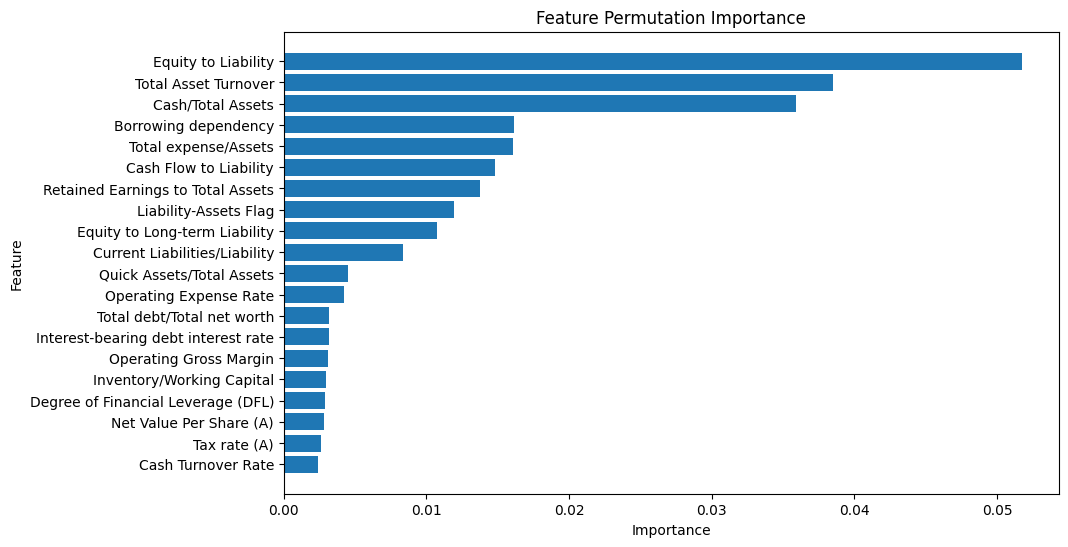

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    taiwan_imputation_scaled_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Equity to Liability', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Equity to Liability', 'Total Asset Turnover', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Equity to Liability', 'Total Asset Turnover', 'Cash/Total Assets', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Total expense/Assets
Original feat removed so far:  ['Equity to Liability', 'Total Asset Turnover', 'Cash/Total Assets', 'Borrowing dependency', 'Total expense/Assets']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Liability
Original feat removed so far:  ['Equity to Liability', 'Total Asset Turnover', 'Cash/Total Assets', 'Borrowing depende

In [ ]:
svm2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   35  1142  178   9      16.43   79.55        86.52     86.29     27.24   
1   34  1139  181  10      15.81   77.27        86.29     86.00     26.25   
2   32  1139  181  12      15.02   72.73        86.29     85.85     24.90   
3   32  1131  189  12      14.48   72.73        85.68     85.26     24.15   
4   27  1155  165  17      14.06   61.36        87.50     86.66     22.88   
5   25  1190  130  19      16.13   56.82        90.15     89.08     25.13   
6   23  1197  123  21      15.75   52.27        90.68     89.44     24.21   
7   19  1252   68  25      21.84   43.18        94.85     93.18     29.01   
8   18  1252   68  26      20.93   40.91        94.85     93.11     27.69   
9   11  1261   59  33      15.71   25.00        95.53     93.26     19.30   
10  14  1260   60  30      18.92   31.82        95.45     93.40     23.73   
11  15  1257   63  29      19.23   34.09        95.23     93.26     24.59   
12  14  1266   54  30      20.59   31.82        95.91     93.84     25.00   
13  14  1267   53  30      20.90   31.82        95.98     93.91     25.23   
14  14  1267   53  30      20.90   31.82        95.98     93.91     25.23   
15  11  1279   41  33      21.15   25.00        96.89     94.57     22.92   
16  11  1281   39  33      22.00   25.00        97.05     94.72     23.40   
17  11  1283   37  33      22.92   25.00        97.20     94.87     23.91   
18   7  1296   24  37      22.58   15.91        98.18     95.53     18.67   
19   6  1299   21  38      22.22   13.64        98.41     95.67     16.90   
20   8  1297   23  36      25.81   18.18        98.26     95.67     21.33   

    balanced_accuracy  num_feat_missing  \
0               83.03                 0   
1               81.78                 1   
2               79.51                 2   
3               79.20                 3   
4               74.43                 4   
5               73.48                 5   
6               71.48                 6   
7               69.02                 7   
8               67.88                 8   
9               60.27                 9   
10              63.64                10   
11              64.66                11   
12              63.86                12   
13              63.90                13   
14              63.90                14   
15              60.95                15   
16              61.02                16   
17              61.10                17   
18              57.05                18   
19              56.02                19   
20              58.22                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Total Asset Turnover'...  
3   ['Equity to Liability', 'Total Asset Turnover'...  
4   ['Equity to Liability', 'Total Asset Turnover'...  
5   ['Equity to Liability', 'Total Asset Turnover'...  
6   ['Equity to Liability', 'Total Asset Turnover'...  
7   ['Equity to Liability', 'Total Asset Turnover'...  
8   ['Equity to Liability', 'Total Asset Turnover'...  
9   ['Equity to Liability', 'Total Asset Turnover'...  
10  ['Equity to Liability', 'Total Asset Turnover'...  
11  ['Equity to Liability', 'Total Asset Turnover'...  
12  ['Equity to Liability', 'Total Asset Turnover'...  
13  ['Equity to Liability', 'Total Asset Turnover'...  
14  ['Equity to Liability', 'Total Asset Turnover'...  
15  ['Equity to Liability', 'Total Asset Turnover'...  
16  ['Equity to Liability', 'Total Asset Turnover'...  
17  ['Equity to Liability', 'Total Asset Turnover'...  
18  ['Equity to Liability', 'Total Asset Turnover'...  
19  ['Equity to Liability', 'Total Asset Turnover'...  
20  ['Equity to Liability', 'Total Asset Turnover'...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 17:32:15.528540

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Assets', 'Total Asset

In [ ]:
svm2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   35  1142  178   9      16.43   79.55        86.52     86.29     27.24   
1   34  1150  170  10      16.67   77.27        87.12     86.80     27.42   
2   34  1153  167  10      16.92   77.27        87.35     87.02     27.76   
3   33  1160  160  11      17.10   75.00        87.88     87.46     27.85   
4   31  1167  153  13      16.85   70.45        88.41     87.83     27.19   
5   34  1158  162  10      17.35   77.27        87.73     87.39     28.33   
6   34  1157  163  10      17.26   77.27        87.65     87.32     28.22   
7   32  1168  152  12      17.39   72.73        88.48     87.98     28.07   
8   31  1168  152  13      16.94   70.45        88.48     87.90     27.31   
9   30  1173  147  14      16.95   68.18        88.86     88.20     27.15   
10  31  1185  135  13      18.67   70.45        89.77     89.15     29.52   
11  29  1185  135  15      17.68   65.91        89.77     89.00     27.88   
12  32  1180  140  12      18.60   72.73        89.39     88.86     29.63   
13  32  1181  139  12      18.71   72.73        89.47     88.93     29.77   
14  31  1183  137  13      18.45   70.45        89.62     89.00     29.25   
15  29  1181  139  15      17.26   65.91        89.47     88.71     27.36   
16  29  1185  135  15      17.68   65.91        89.77     89.00     27.88   
17  29  1188  132  15      18.01   65.91        90.00     89.22     28.29   
18  30  1195  125  14      19.35   68.18        90.53     89.81     30.15   
19  27  1219  101  17      21.09   61.36        92.35     91.35     31.40   
20  25  1217  103  19      19.53   56.82        92.20     91.06     29.07   

    balanced_accuracy  num_feat_missing  \
0               83.03                 0   
1               82.20                 1   
2               82.31                 2   
3               81.44                 3   
4               79.43                 4   
5               82.50                 5   
6               82.46                 6   
7               80.61                 7   
8               79.47                 8   
9               78.52                 9   
10              80.11                10   
11              77.84                11   
12              81.06                12   
13              81.10                13   
14              80.04                14   
15              77.69                15   
16              77.84                16   
17              77.95                17   
18              79.36                18   
19              76.86                19   
20              74.51                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Total Asset Turnover'...  
3   ['Equity to Liability', 'Total Asset Turnover'...  
4   ['Equity to Liability', 'Total Asset Turnover'...  
5   ['Equity to Liability', 'Total Asset Turnover'...  
6   ['Equity to Liability', 'Total Asset Turnover'...  
7   ['Equity to Liability', 'Total Asset Turnover'...  
8   ['Equity to Liability', 'Total Asset Turnover'...  
9   ['Equity to Liability', 'Total Asset Turnover'...  
10  ['Equity to Liability', 'Total Asset Turnover'...  
11  ['Equity to Liability', 'Total Asset Turnover'...  
12  ['Equity to Liability', 'Total Asset Turnover'...  
13  ['Equity to Liability', 'Total Asset Turnover'...  
14  ['Equity to Liability', 'Total Asset Turnover'...  
15  ['Equity to Liability', 'Total Asset Turnover'...  
16  ['Equity to Liability', 'Total Asset Turnover'...  
17  ['Equity to Liability', 'Total Asset Turnover'...  
18  ['Equity to Liability', 'Total Asset Turnover'...  
19  ['Equity to Liability', 'Total Asset Turnover'...  
20  ['Equity to Liability', 'Total Asset Turnover'...

##**Logistic Regression**

In [ ]:
len(lr_X_test.columns)

61

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr2_param_grid = {
      'C': [5.0],
      'penalty': ['l1'],
      'solver': ['liblinear']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 3, 3, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 17:38:48.985812

Nested Cross-validation Results:
Individual scores: [0.83490466 0.85802312 0.81995741]
Average nested CV score: 0.838 (+/- 0.031)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.838
2025-01-16 17:40:15.681748

Execution time: 1.44 minutes




```
Starting hyperparameter tuning at: 2025-01-15 20:40:22.760568

Nested Cross-validation Results:
Individual scores: [0.83121148 0.8304565  0.81739914]
Average nested CV score: 0.826 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.838
2025-01-15 20:42:45.155849

Execution time: 2.37 minutes
```



In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
11                          Equity to Liability  1.011160e-01  0.018673
1                          Borrowing dependency  3.499802e-02  0.005016
23                            Cash/Total Assets  3.293388e-02  0.007631
20                         Total expense/Assets  2.199000e-02  0.000780
32                       Cash Flow to Liability  2.049275e-02  0.004405
29                         Total Asset Turnover  1.823897e-02  0.007316
2             Retained Earnings to Total Assets  1.486637e-02  0.002990
5                       Net Value Per Share (A)  9.752299e-03  0.009680
14                        Liability-Assets Flag  9.034188e-03  0.000097
50                Current Liabilities/Liability  6.705493e-03  0.002916
43                           Cash Turnover Rate  6.553518e-03  0.006969
27                          Cash Flow to Equity  5.739508e-03  0.003359
28                    Quick Assets/Total Assets  5.568591e-03  0.001884
17                                CFO to Assets  4.620904e-03  0.003250
19  Inventory and accounts receivable/Net value  3.201472e-03  0.002786
49              Inventory Turnover Rate (times)  3.106434e-03  0.002787
46                   Total debt/Total net worth  3.106111e-03  0.000093
34                      Total Asset Growth Rate  2.973618e-03  0.003094
33           Degree of Financial Leverage (DFL)  2.575707e-03  0.000071
9                   Operating profit per person  2.537821e-03  0.003580
10                Equity to Long-term Liability  2.234841e-03  0.001266
52                       Operating Expense Rate  1.704653e-03  0.003200
8           Operating Profit Per Share (Yuan ¥)  1.268103e-03  0.001962
47                    Total assets to GNP price  1.212136e-03  0.001369
48          Interest-bearing debt interest rate  9.468262e-04  0.001449
15                       Operating Gross Margin  9.466109e-04  0.002139
55                 Accounts Receivable Turnover  9.091555e-04  0.001062
39         Long-term fund suitability ratio (A)  6.251184e-04  0.000176
12                                 Tax rate (A)  6.060678e-04  0.002908
53                  Current Asset Turnover Rate  4.167456e-04  0.000114
37                 Operating Profit Growth Rate  2.083728e-04  0.000093
57                  Inventory/Current Liability  1.515439e-04  0.000128
58                   Revenue Per Share (Yuan ¥)  9.471491e-05  0.000000
6          Continuous interest rate (after tax)  9.471491e-05  0.000104
16                       Interest Expense Ratio  7.577193e-05  0.000038
26                           No-credit Interval  7.577193e-05  0.000110
59               Quick Assets/Current Liability  5.682894e-05  0.000046
40                           Revenue per person  5.682894e-05  0.000046
25                    Inventory/Working Capital  1.894298e-05  0.000250
24             After-tax Net Profit Growth Rate  2.220446e-17  0.000060
56                      Average Collection Days -7.577193e-05  0.000071
51                   Allocation rate per person -9.471491e-05  0.000060
42        Research and development expense rate -3.029801e-04  0.000994
31              Fixed Assets Turnover Frequency -6.064983e-04  0.001784
45                    Quick Asset Turnover Rate -8.333836e-04  0.002967
21                       Cash/Current Liability -1.344736e-03  0.002273

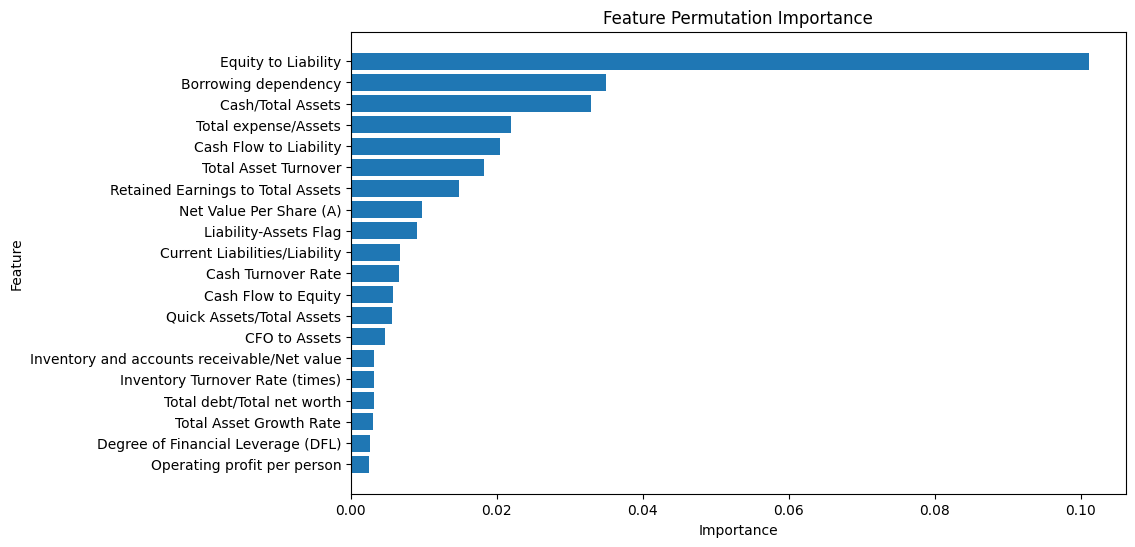

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Equity to Liability', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Equity to Liability', 'Borrowing dependency', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Total expense/Assets
Original feat removed so far:  ['Equity to Liability', 'Borrowing dependency', 'Cash/Total Assets', 'Total expense/Assets']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Liability
Original feat removed so far:  ['Equity to Liability', 'Borrowing dependency', 'Cash/Total Assets', 'Total expense/Assets', 'Cash Flow to Liability']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Equity to Liability', 'Borrowing dependency', 'Cash/Total Assets', 'Total expense/A

In [ ]:
lr2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1148  172   8      17.31   81.82        86.97     86.80     28.57   
1   33  1149  171  11      16.18   75.00        87.05     86.66     26.61   
2   23  1190  130  21      15.03   52.27        90.15     88.93     23.35   
3   22  1188  132  22      14.29   50.00        90.00     88.71     22.22   
4   18  1209  111  26      13.95   40.91        91.59     89.96     20.81   
5   17  1214  106  27      13.82   38.64        91.97     90.25     20.36   
6   17  1231   89  27      16.04   38.64        93.26     91.50     22.67   
7    6  1277   43  38      12.24   13.64        96.74     94.06     12.90   
8    3  1288   32  41       8.57    6.82        97.58     94.65      7.59   
9    2  1288   32  42       5.88    4.55        97.58     94.57      5.13   
10   4  1283   37  40       9.76    9.09        97.20     94.35      9.41   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               84.39                 0   
1               81.02                 1   
2               71.21                 2   
3               70.00                 3   
4               66.25                 4   
5               65.30                 5   
6               65.95                 6   
7               55.19                 7   
8               52.20                 8   
9               51.06                 9   
10              53.14                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Borrowing dependency'...  
3   ['Equity to Liability', 'Borrowing dependency'...  
4   ['Equity to Liability', 'Borrowing dependency'...  
5   ['Equity to Liability', 'Borrowing dependency'...  
6   ['Equity to Liability', 'Borrowing dependency'...  
7   ['Equity to Liability', 'Borrowing dependency'...  
8   ['Equity to Liability', 'Borrowing dependency'...  
9   ['Equity to Liability', 'Borrowing dependency'...  
10  ['Equity to Liability', 'Borrowing dependency'...  
11  ['Equity to Liability', 'Borrowing dependency'...  
12  ['Equity to Liability', 'Borrowing dependency'...  
13  ['Equity to Liability', 'Borrowing dependency'...  
14  ['Equity to Liability', 'Borrowing dependency'...  
15  ['Equity to Liability', 'Borrowing dependency'...  
16  ['Equity to Liability', 'Borrowing dependency'...  
17  ['Equity to Liability', 'Borrowing dependency'...  
18  ['Equity to Liability', 'Borrowing dependency'...  
19  ['Equity to Liability', 'Borrowing dependency'...  
20  ['Equity to Liability', 'Borrowing dependency'...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 17:40:36.173476

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Assets', 'Total Asset

In [ ]:
lr2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1148  172   8      17.31   81.82        86.97     86.80     28.57   
1   36  1161  159   8      18.46   81.82        87.95     87.76     30.13   
2   34  1179  141  10      19.43   77.27        89.32     88.93     31.05   
3   32  1182  138  12      18.82   72.73        89.55     89.00     29.91   
4   33  1176  144  11      18.64   75.00        89.09     88.64     29.86   
5   33  1173  147  11      18.33   75.00        88.86     88.42     29.46   
6   34  1179  141  10      19.43   77.27        89.32     88.93     31.05   
7   31  1187  133  13      18.90   70.45        89.92     89.30     29.81   
8   30  1197  123  14      19.61   68.18        90.68     89.96     30.46   
9   29  1197  123  15      19.08   65.91        90.68     89.88     29.59   
10  30  1201  119  14      20.13   68.18        90.98     90.25     31.09   
11  28  1195  125  16      18.30   63.64        90.53     89.66     28.43   
12  28  1195  125  16      18.30   63.64        90.53     89.66     28.43   
13  28  1191  129  16      17.83   63.64        90.23     89.37     27.86   
14  28  1203  117  16      19.31   63.64        91.14     90.25     29.63   
15  28  1201  119  16      19.05   63.64        90.98     90.10     29.32   
16  28  1205  115  16      19.58   63.64        91.29     90.40     29.95   
17  28  1206  114  16      19.72   63.64        91.36     90.47     30.11   
18  28  1206  114  16      19.72   63.64        91.36     90.47     30.11   
19  26  1212  108  18      19.40   59.09        91.82     90.76     29.21   
20  27  1215  105  17      20.45   61.36        92.05     91.06     30.68   

    balanced_accuracy  num_feat_missing  \
0               84.39                 0   
1               84.89                 1   
2               83.30                 2   
3               81.14                 3   
4               82.05                 4   
5               81.93                 5   
6               83.30                 6   
7               80.19                 7   
8               79.43                 8   
9               78.30                 9   
10              79.58                10   
11              77.08                11   
12              77.08                12   
13              76.93                13   
14              77.39                14   
15              77.31                15   
16              77.46                16   
17              77.50                17   
18              77.50                18   
19              75.45                19   
20              76.70                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Borrowing dependency'...  
3   ['Equity to Liability', 'Borrowing dependency'...  
4   ['Equity to Liability', 'Borrowing dependency'...  
5   ['Equity to Liability', 'Borrowing dependency'...  
6   ['Equity to Liability', 'Borrowing dependency'...  
7   ['Equity to Liability', 'Borrowing dependency'...  
8   ['Equity to Liability', 'Borrowing dependency'...  
9   ['Equity to Liability', 'Borrowing dependency'...  
10  ['Equity to Liability', 'Borrowing dependency'...  
11  ['Equity to Liability', 'Borrowing dependency'...  
12  ['Equity to Liability', 'Borrowing dependency'...  
13  ['Equity to Liability', 'Borrowing dependency'...  
14  ['Equity to Liability', 'Borrowing dependency'...  
15  ['Equity to Liability', 'Borrowing dependency'...  
16  ['Equity to Liability', 'Borrowing dependency'...  
17  ['Equity to Liability', 'Borrowing dependency'...  
18  ['Equity to Liability', 'Borrowing dependency'...  
19  ['Equity to Liability', 'Borrowing dependency'...  
20  ['Equity to Liability', 'Borrowing dependency'...

# **Results comparison**

##**F1-score**

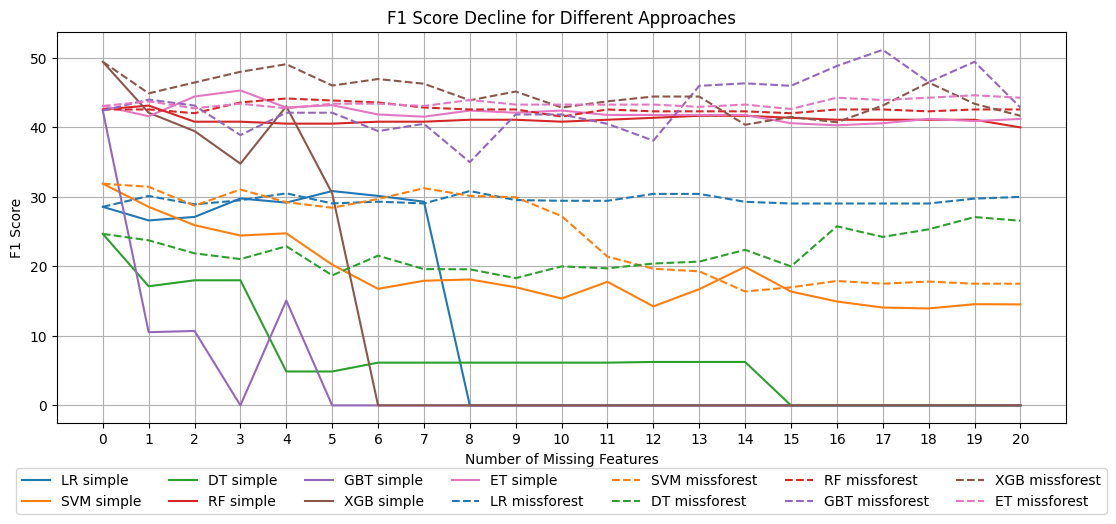

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

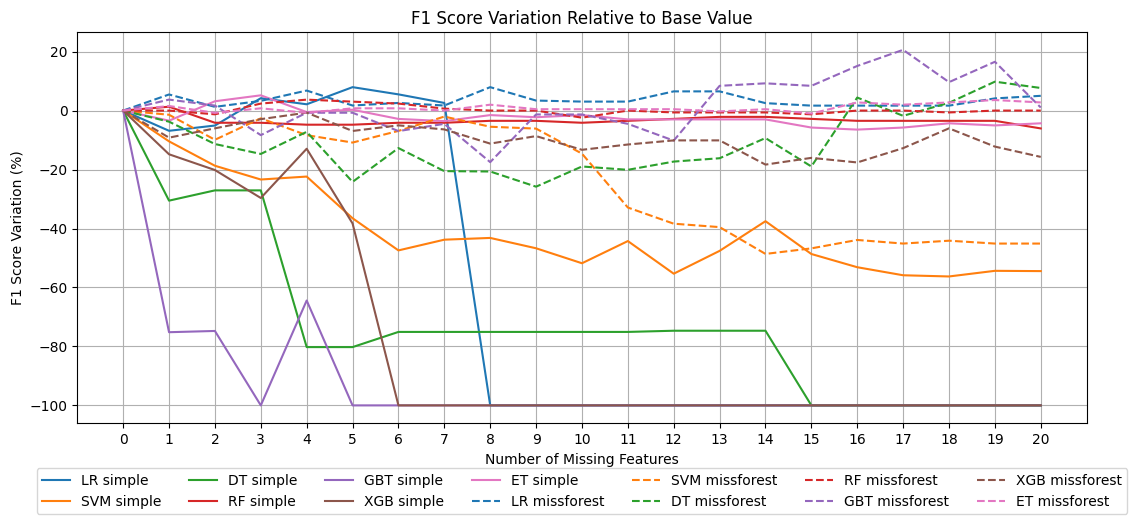

In [ ]:
# # Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced Accuracy**

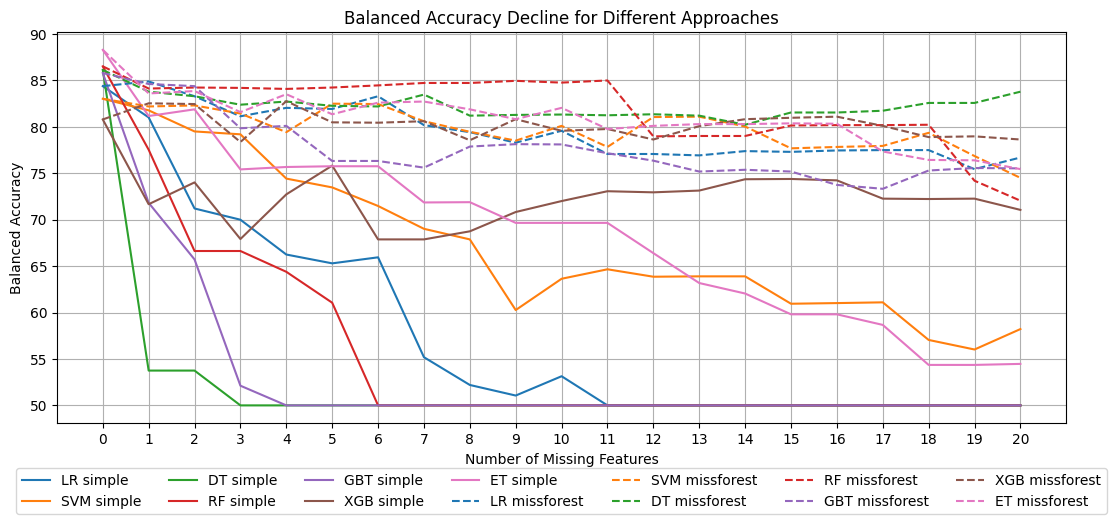

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

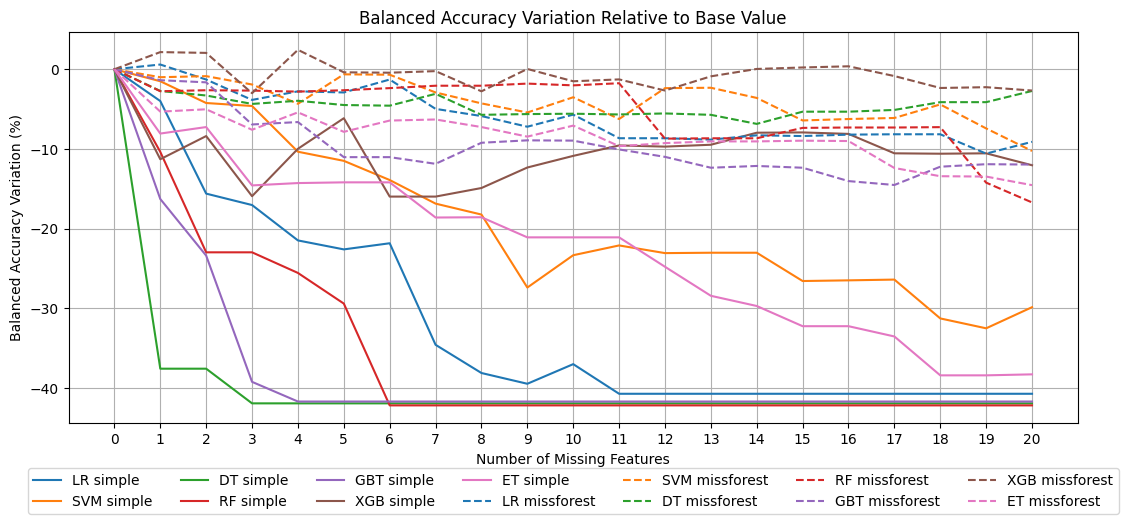

In [ ]:
# # Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf,
}

all_data = combine_datasets(
    dataset_dict,
    'Taiwanese Bankruptcy', 'Scenario 2: drop intercorrelated',
    RANDOM_STATE
)
save_dataset(all_data, 'taiwanese_bankruptcy_scenario2_seed_2025.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0    36  1148  172   8      17.31   81.82        86.97     86.80     28.57   
1    33  1149  171  11      16.18   75.00        87.05     86.66     26.61   
2    32  1160  160  12      16.67   72.73        87.88     87.39     27.12   
3    32  1181  139  12      18.71   72.73        89.47     88.93     29.77   
4    34  1165  155  10      17.99   77.27        88.26     87.90     29.18   
..   ..   ...  ...  ..        ...     ...          ...       ...       ...   
583  30  1221   99  14      23.26   68.18        92.50     91.72     34.68   
584  27  1232   88  17      23.48   61.36        93.33     92.30     33.96   
585  26  1238   82  18      24.07   59.09        93.79     92.67     34.21   
586  26  1237   83  18      23.85   59.09        93.71     92.60     33.99   
587  25  1242   78  19      24.27   56.82        94.09     92.89     34.01   

     balanced_accuracy  num_feat_missing  \
0                84.39                 0   
1                81.02                 1   
2                80.30                 2   
3                81.10                 3   
4                82.77                 4   
..                 ...               ...   
583              80.34                16   
584              77.35                17   
585              76.44                18   
586              76.40                19   
587              75.45                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1                      ['Equity to Liability'] imputed      lr_perf   
2    ['Equity to Liability', 'Total expense/Assets'...      lr_perf   
3    ['Equity to Liability', 'Total expense/Assets'...      lr_perf   
4    ['Equity to Liability', 'Total expense/Assets'...      lr_perf   
..                                                 ...          ...   
583  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  et2_perf_mf   
584  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  et2_perf_mf   
585  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  et2_perf_mf   
586  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  et2_perf_mf   
587  ['Tax rate (A)', 'Interest Coverage Ratio (Int...  et2_perf_mf   

                   source                          scenario  random_state  \
0    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2025   
1    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2025   
2    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2025   
3    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2025   
4    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2025   
..                    ...                               ...           ...   
583  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2025   
584  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2025   
585  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2025   
586  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2025   
587  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          2025   

                metric  
0             f1 score  
1             f1 score  
2             f1 score  
3             f1 score  
4             f1 score  
..                 ...  
583  balanced accuracy  
584  balanced accuracy  
585  balanced accuracy  
586  balanced accuracy  
587  balanced accuracy  

[588 rows x 17 columns]